# Case Study : Telecom Churn Case Study

### Problem Statement
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, 
the telecommunications industry experiences an average of 15-25% annual churn rate.
Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition. reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

### Business Goal
In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

### Steps:-
1. Reading, understanding and visualising the data
2. Preparing the data for modelling
3. Building the model
4. Evaluate the model

In [1]:
import pandas as pd
import numpy as np
import warnings

import math
import itertools

from scipy import special 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import math
from IPython.display import Markdown, display ,HTML


from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_curve, classification_report
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

import imblearn
from imblearn.over_sampling import SMOTE

sns.set(style="whitegrid")
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', -1) # make sure data and columns are displayed correctly withput purge
pd.options.display.float_format = '{:20,.2f}'.format # display float value with correct precision 


warnings.filterwarnings('ignore')

C:\Users\sonalli.panwar\AppData\Local\Temp\ipykernel_12464\115688719.py:35: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1) # make sure data and columns are displayed correctly withput purge


In [2]:
def log(string):
    display(Markdown("> <span style='color:blue'>"+string+"</span>"))

def header(string):
    display(Markdown("------ "))
    display(Markdown("### "+string))
    
def header_red(string):
    display(Markdown("> <span style='color:red'>"+string))   

def get_variable_type(element) :
    """
     Check is columns are of Contineous or Categorical variable.
     Assumption is that if 
                 unique count < 20 then categorical 
                 unique count >= 20 and dtype = [int64 or float64] then contineous
     """
    if element==0:
        return "Not Known"
    elif element < 20 and element!=0 :
        return "Categorical"
    elif element >= 20 and element!=0 :
        return "Contineous" 

In [3]:
def get_meta_data(dataframe) :
    """
     Method to get Meta-Data about any dataframe passed 
    """
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes.astype(str), 
                    'Non_Null_Count': dataframe.count(axis = 0).astype(int), 
                    'Null_Count': dataframe.isnull().sum().astype(int), 
                    'Null_Percentage': dataframe.isnull().sum()/len(dataframe) * 100, 
                    'Unique_Values_Count': dataframe.nunique().astype(int) 
                     })
    
    metadata_matrix = predict_variable_type(metadata_matrix)
    return metadata_matrix

In [4]:
def display_columns_with_1_unique_value(dataframe):
    unique_values_count_1 = dataframe[dataframe["Unique_Values_Count"] == 1]
    drop_value_col = unique_values_count_1.index.tolist()
    lenght = len(drop_value_col)
    header("Columns with only one unique value : "+str(lenght))
    if lenght == 0 :
        header_red("No columns with only one unique values.")  
    else :    
        log("Columns with only one unique value :")
        for index,item in enumerate(drop_value_col) :
            print(index,".",item)

In [5]:
def predict_variable_type(metadata_matrix):
    metadata_matrix["Variable_Type"] = metadata_matrix["Unique_Values_Count"].apply(get_variable_type).astype(str)
    metadata_matrix["frequency"] = metadata_matrix["Null_Count"] - metadata_matrix["Null_Count"]
    metadata_matrix["frequency"].astype(int)
    return metadata_matrix 

In [6]:
def list_potential_categorical_type(dataframe,main) :
    header("Stats for potential Categorical datatype columns")
    metadata_matrix_categorical = dataframe[dataframe["Variable_Type"] == "Categorical"]
    # TO DO *** Add check to skip below if there is no Categorical values 
    length = len(metadata_matrix_categorical)
    if length == 0 :
        header_red("No Categorical columns in given dataset.")  
    else :    
        metadata_matrix_categorical = metadata_matrix_categorical.filter(["Datatype","Unique_Values_Count"])
        metadata_matrix_categorical.sort_values(["Unique_Values_Count"], axis=0,ascending=False, inplace=True)
        col_to_check = metadata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        for name in col_to_check :
            name_list.append(name)
            values_list.append(main[name].unique())
        temp = pd.DataFrame({"index":name_list,"Unique_Values":values_list})
        metadata_matrix_categorical = metadata_matrix_categorical.reset_index()
        metadata_matrix_categorical = pd.merge(metadata_matrix_categorical,temp,how='inner',on='index')
        display(metadata_matrix_categorical.set_index("index")) 


In [7]:
def plot_data_type_pie_chat(dataframe) : 
        header("Stats for Datatype Percentage Distribution")
        dataframe_group = dataframe.groupby("Datatype").frequency.count().reset_index()
        dataframe_group.sort_values(["Datatype"], axis=0,ascending=False, inplace=True)
        trace = go.Pie(labels=dataframe_group["Datatype"].tolist(), values=dataframe_group["frequency"].tolist())
        layout = go.Layout(title="Datatype Percentage Distribution")
        fig = go.Figure(data=[trace], layout=layout)    
        py.offline.iplot(fig)

In [8]:
def get_potential_categorical_type(dataframe,main,unique_count) :
    metadata_matrix_categorical = dataframe[dataframe["Variable_Type"] == "Categorical"]
    metadata_matrix_categorical = dataframe[dataframe["Unique_Values_Count"] == unique_count]
    length = len(metadata_matrix_categorical)
    if length == 0 :
        header_red("No Categorical columns in given dataset.")  
    else :    
        metadata_matrix_categorical = metadata_matrix_categorical.filter(["Datatype","Unique_Values_Count"])
        metadata_matrix_categorical.sort_values(["Unique_Values_Count"], axis=0,ascending=False, inplace=True)
        col_to_check = metadata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        for name in col_to_check :
            name_list.append(name)
            values_list.append(main[name].unique())
        temp = pd.DataFrame({"index":name_list,"Unique_Values":values_list})
        metadata_matrix_categorical = metadata_matrix_categorical.reset_index()
        metadata_matrix_categorical = pd.merge(metadata_matrix_categorical,temp,how='inner',on='index')
        display(metadata_matrix_categorical.set_index("index")) 

In [9]:
def color_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for value 
    greater than 10 , black otherwise.
    """
    color = 'red' if val > 5 else 'black'
    return 'color: %s' % color

def heatmap(x,y,dataframe):
    plt.figure(figsize=(x,y))
    sns.heatmap(dataframe.corr(),cmap="OrRd",annot=True)
    plt.show()

### Loading dataset for telecom chrun analysis

In [10]:
telecom_df = pd.read_csv("telecom_churn_data.csv")
telecom_df.head(10)

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,...,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,...,NaN,252.00,252.00,252.00,NaN,30.13,1.32,5.75,0.00,83.57,150.76,109.61,0.00,212.17,212.17,212.17,NaN,212.17,212.17,212.17,NaN,0.00,0.00,0.00,NaN,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1.00,1.00,1.00,NaN,968,30.40,0.00,101.20,3.58
1,7001865778,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.05,355.07,268.32,86.28,24.11,78.68,7.68,18.34,15.74,99.84,304.76,53.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23.88,74.56,7.68,18.34,11.51,75.94,291.86,53.76,0.00,0.00,0.00,0.00,0.00,2.91,0.00,0.00,35.39,150.51,299.54,72.11,0.23,...,NaN,NaN,154.00,50.00,NaN,0.00,108.07,365.47,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,NaN,NaN,28.61,7.60,NaN,NaN,0.00,0.00,NaN,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,NaN,1.00,1.00,NaN,1006,0.00,0.00,0.00,0.00
2,7001625959,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.69,189.06,210.23,290.71,11.54,55.24,37.26,74.81,143.33,220.59,208.36,118.91,0.00,0.00,0.00,38.49,0.00,0.00,0.00,70.94,7.19,28.74,13.58,14.39,29.34,16.86,38.46,28.16,24.11,21.79,15.61,22.24,0.00,135.54,45.76,0.48,60.66,67.41,67.66,64.81,4.34,...,0.00,NaN,NaN,NaN,46.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.42,NaN,NaN,NaN,2.84,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1.00,1103,0.00,0.00,4.17,0.00
3,7001204172,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.34,251.10,508.05,389.50,99.91,54.39,310.98,241.71,123.31,109.01,71.68,113.54,0.00,54.86,44.38,0.00,0.00,28.09,39.04,0.00,73.68,34.81,10.61,15.49,107.43,83.21,22.46,65.46,1.91,0.65,4.91,2.06,0.00,0.00,0.00,0.00,183.03,118.68,37.99,83.03,26.23,...,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,2491,0.00,0.00,0.00,0.00
4,7000142493,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.64,309.88,238.17,163.43,50.31,149.44,83.89,58.78,76.96,91.88,124.26,45.81,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50.31,149.44,83.89,58.78,67.64,91.88,124.26,37.89,0.00,0.00,0.00,1.93,0.00,0.00,0.00,0.00,117.96,241.33,208.16,98.61,0.00,...,NaN,56.00,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.00,NaN,NaN,NaN,1526,0.00,0.00,0.00,0.00
5,7000286308,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,50.26,58.81,83.39,170.83,50.16,43.63,85.48,138.79,19.28,13.4

In [11]:
telecom_df.shape

(99999, 226)

In [12]:
telecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [13]:
telecom_df.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,...,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,"99,999.00","99,999.00","98,981.00","98,981.00","98,981.00","99,999.00","99,999.00","99,999.00","99,999.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00","96,140.00","94,621.00","92,254.00","96,062.00",...,"25,922.00","25,153.00","25,571.00","26,339.00","25,922.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","25,153.00","25,571.00","26,339.00","25,922.00","25,153.00","25,571.00","26,339.00","25,922.00","25,153.00","25,571.00","26,339.00","25,922.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","25,153.00","25,571.00","26,339.00","25,922.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00"
mean,"7,001,207,270.39",109.00,0.00,0.00,0.00,282.99,278.54,279.15,261.65,132.40,133.67,133.02,130.30,197.94,197.05,196.57,190.34,9.95,7.15,7.29,6.34,13.91,9.82,9.97,8.56,47.10,46.47,45.89,44.58,93.34,91.40,91.76,90.46,3.75,3.79,3.68,3.66,1.12,1.37,1.43,1.23,144.20,141.67,141.33,138.71,79.83,83.30,83.28,82.34,87.30,...,0.66,192.60,200.98,197.53,192.73,51.90,51.23,50.17,44.72,121.40,129.00,135.41,136.06,89.56,89.38,91.17,100.26,86.40,85.91,86.60,93.71,0.03,0.02,0.02,0.02,0.08,0.08,0.08,0.07,0.39,0.44,0.45,0.39,0.08,0.08,0.08,0.09,0.07,0.08,0.08,0.08,0.91,0.91,0.89,0.86,"1,219.85",68.17,66.84,60.02,3.30
std,"695,669.39",0.00,0.00,0.00,0.00,328.44,338.16,344.47,342.00,297.21,308.79,308.95,308.48,316.85,325.86,327.17,319.40,72.83,73.45,68.40,57.14,71.44,58.46,64.71,58.44,150.86,155.32,151.18,148.00,162.78,157.49,156.54,158.68,14.23,14.26,13.27,13.46,5.45,7.53,6.78,5.62,251.75,248.73,245.91,245.93,252.48,263.63,265.49,267.18,255.62,...,1.41,192.65,196.79,191.30,188.40,213.36,212.30,212.35,198.65,544.25,541.49,558.78,577.39,193.12,195.89,188.18,216.29,172.77,176.38,168.25,171.38,0.16,0.15,0.14,0.13,0.30,0.30,0.30,0.28,1.50,1.64,1.63,1.35,0.36,0.39,0.38,0.38,0.57,0.63,0.66,0.65,0.28,0.29,0.31,0.35,954.73,267.58,271.20,253.94,32.41
min,"7,000,000,074.00",109.00,0.00,0.00,0.00,"-2,258.71","-2,014.05",-945.81,"-1,899.51",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,

## Data Preparation

### Handling missing values in columns

In [14]:
# Cheking percent of missing values in columns
df_missing_columns = (round(((telecom_df.isnull().sum()/len(telecom_df.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
df_missing_columns

,null
arpu_3g_6,74.85
night_pck_user_6,74.85
total_rech_data_6,74.85
arpu_2g_6,74.85
max_rech_data_6,74.85
...,...
max_rech_amt_7,0.00
max_rech_amt_6,0.00
total_rech_amt_9,0.00
total_rech_amt_8,0.00


In [15]:
# Let us first extract list of columns containing recharge amount
amt_recharge_columns =  telecom_df.columns[telecom_df.columns.str.contains('rech_amt|rech_data')]
print(amt_recharge_columns)

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'max_rech_amt_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6',
       'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'av_rech_amt_data_9'],
      dtype='object')


#### Analysis: From above features we can derive more meaningful information :

    Total recharge amount
    Total recharge for data
    Maximum recharge amount
    Last date of Recharging the data
    Average recharge amount for data.
    Maximum recharge for data</span>

In [16]:
# Checking missing values percentages
telecom_df_null_check = 100*telecom_df.loc[:,amt_recharge_columns].isnull().sum()/len(telecom_df)
df = pd.DataFrame(telecom_df_null_check)
df.rename(columns={0:'Null_Percentage'}, inplace=True)
df = pd.DataFrame(df.Null_Percentage).style.applymap(color_red)
display(df)

,Null_Percentage
total_rech_amt_6,0.000000
total_rech_amt_7,0.000000
total_rech_amt_8,0.000000
total_rech_amt_9,0.000000
max_rech_amt_6,0.000000
max_rech_amt_7,0.000000
max_rech_amt_8,0.000000
max_rech_amt_9,0.000000
date_of_last_rech_data_6,74.846748
date_of_last_rech_data_7,74.428744


**Analysis:** We can see more then **74%** values for **recharge** related data are missing.

In [17]:
telecom_df.loc[:,amt_recharge_columns].describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
count,"99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","25,153.00","25,571.00","26,339.00","25,922.00","25,153.00","25,571.00","26,339.00","25,922.00","25,153.00","25,571.00","26,339.00","25,922.00"
mean,327.51,322.96,324.16,303.35,104.64,104.75,107.73,101.94,2.46,2.67,2.65,2.44,126.39,126.73,125.72,124.94,192.60,200.98,197.53,192.73
std,398.02,408.11,416.54,404.59,120.61,124.52,126.90,125.38,2.79,3.03,3.07,2.52,108.48,109.77,109.44,111.36,192.65,196.79,191.30,188.40
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.50,0.50,1.00
25%,109.00,100.00,90.00,52.00,30.00,30.00,30.00,28.00,1.00,1.00,1.00,1.00,25.00,25.00,25.00,25.00,82.00,92.00,87.00,69.00
50%,230.00,220.00,225.00,200.00,110.00,110.00,98.00,61.00,1.00,1.00,1.00,2.00,145.00,145.00,145.00,145.00,154.00,154.00,154.00,164.00
75%,437.50,428.00,434.50,415.00,120.00,128.00,144.00,144.00,3.00,3.00,3.00,3.00,177.00,177.00,179.00,179.00,252.00,252.00,252.00,252.00
max,"35,190.00","40,335.00","45,320.00","37,235.00","4,010.00","4,010.00","4,449.00","3,399.00",61.00,54.00,60.00,84.00,"1,555.00","1,555.00","1,555.00","1,555.00","7,546.00","4,365.00","4,076.00","4,061.00"


**Analysis:** We can create new feature as total_rech_amt_data using total_rech_data and av_rech_amt_data to capture amount utilized by customer for data.

**Analysis:** Also as the minimum value is 1 we can impute the NA values by 0, Considering there were no recharges done by the customer.

In [18]:
telecom_df['total_rech_data_6'] = telecom_df['total_rech_data_6'].replace(np.NaN,0.0)
telecom_df['total_rech_data_7'] = telecom_df['total_rech_data_7'].replace(np.NaN,0.0)
telecom_df['total_rech_data_8'] = telecom_df['total_rech_data_8'].replace(np.NaN,0.0)

In [19]:
telecom_df['av_rech_amt_data_6'] = telecom_df['av_rech_amt_data_6'].replace(np.NaN,0.0)
telecom_df['av_rech_amt_data_7'] = telecom_df['av_rech_amt_data_7'].replace(np.NaN,0.0)
telecom_df['av_rech_amt_data_8'] = telecom_df['av_rech_amt_data_8'].replace(np.NaN,0.0)

In [20]:
# let's adding new column total recharge amount for data: total_rech_amt_data for calculating High Value customer process
telecom_df['total_rech_amt_data_6'] = telecom_df.av_rech_amt_data_6 * telecom_df.total_rech_data_6
telecom_df['total_rech_amt_data_7'] = telecom_df.av_rech_amt_data_7 * telecom_df.total_rech_data_7
telecom_df['total_rech_amt_data_8'] = telecom_df.av_rech_amt_data_8 * telecom_df.total_rech_data_8

**Analysis:** Defining total average recharge amount for good phase for months 6 and 7 (the good phase)

In [21]:
telecom_df['total_avg_rech_amnt_6_7_GPhase'] = (telecom_df.total_rech_amt_6 + telecom_df.total_rech_amt_data_6 \
                                               + telecom_df.total_rech_amt_7+ telecom_df.total_rech_amt_data_7)/2

### Filter high-value customers

#### Define high-value customers as follows:
Those who have recharged with an amount more than or equal to X, where X is greater than 70th percentile of the average recharge amount in the first two months (the good phase)

In [22]:
# create a filter for values greater than 70th percentile of total average recharge amount for good phase 
high_value_filter = telecom_df.total_avg_rech_amnt_6_7_GPhase.quantile(0.7)

log('70 percentile of 6th and 7th months avg recharge amount: '+str(high_value_filter))

telecom_df_high_val_cust = telecom_df[telecom_df.total_avg_rech_amnt_6_7_GPhase > high_value_filter]
log('Dataframe Shape after Filtering High Value Customers: ' + str(telecom_df_high_val_cust.shape))

> <span style='color:blue'>70 percentile of 6th and 7th months avg recharge amount: 478.0</span>

> <span style='color:blue'>Dataframe Shape after Filtering High Value Customers: (29953, 230)</span>

In [23]:
#### Tag churners and remove attributes of the churn phase


Tag churners and remove attributes of the churn phase

* Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase.
* The attributes you need to use to tag churners are:total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9
* After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [24]:
high_val_cust_9 = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9','vol_3g_mb_9']

In [25]:
# Checking the NA/Null values are present or Not
df = 100*telecom_df_high_val_cust.loc[:,high_val_cust_9].isnull().sum()/len(telecom_df_high_val_cust)
df = pd.DataFrame(df)
df.rename(columns={0:'Null_Percentage'}, inplace=True)
df = pd.DataFrame(df.Null_Percentage).style.applymap(color_red)
display(df)

,Null_Percentage
total_ic_mou_9,0.000000
total_og_mou_9,0.000000
vol_2g_mb_9,0.000000
vol_3g_mb_9,0.000000


In [26]:
# Initially set all the values as 0
telecom_df_high_val_cust['churn']= 0

In [27]:
#is_churned boolean flag for customers where above values are zero
is_churned = (telecom_df_high_val_cust.total_ic_mou_9 == 0) & \
             (telecom_df_high_val_cust.total_og_mou_9 == 0) & \
             (telecom_df_high_val_cust.vol_2g_mb_9 ==0) & \
             (telecom_df_high_val_cust.vol_3g_mb_9 ==0)

In [28]:
# set all which having is_churned True condition as 1
telecom_df_high_val_cust.loc[is_churned,'churn']=1

In [29]:
# let us check what's the % of churned customers
100*telecom_df_high_val_cust.churn.sum()/len(telecom_df_high_val_cust)

8.122725603445398

After tagging churners, remove all the attributes corresponding to the churn phase **(all attributes having ‘ _9’, etc. in their names)**

In [30]:
churn_month_columns =  telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('_9')]

In [31]:
# drop all columns corresponding to the churn phase
telecom_df_high_val_cust.drop(churn_month_columns,axis=1,inplace=True)

## EDA

**Preprocess data (convert columns to appropriate formats, handle missing values, etc.)**

In [32]:
list_potential_categorical_type(get_meta_data(telecom_df_high_val_cust),telecom_df_high_val_cust)


------ 

### Stats for potential Categorical datatype columns

,Datatype,Unique_Values_Count,Unique_Values
index,,,
monthly_3g_7,int64,15,"[1, 0, 2, 5, 3, 8, 4, 7, 6, 9, 11, 12, 14, 10, 16]"
monthly_3g_8,int64,12,"[1, 0, 2, 7, 3, 4, 6, 5, 8, 10, 9, 16]"
monthly_3g_6,int64,12,"[1, 0, 4, 2, 3, 5, 7, 6, 9, 8, 11, 14]"
monthly_2g_8,int64,6,"[0, 1, 2, 5, 3, 4]"
monthly_2g_7,int64,6,"[0, 1, 2, 5, 4, 3]"
monthly_2g_6,int64,5,"[0, 2, 1, 3, 4]"
night_pck_user_6,float64,2,"[0.0, nan, 1.0]"
night_pck_user_7,float64,2,"[0.0, nan, 1.0]"
fb_user_8,float64,2,"[1.0, nan, 0.0]"


**Analysis:** Dropping above features with only **one unique** value as they will not add any value to our model building and analyis

In [33]:
drop_col_with_unique_col =['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 
                          'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 
                          'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 
                          'std_og_t2c_mou_8',  'std_ic_t2o_mou_6', 
                          'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']

In [34]:
log("Features before dropping unique values : "+ str(telecom_df_high_val_cust.shape[1]))
telecom_df_high_val_cust.drop(drop_col_with_unique_col,axis=1,inplace=True)
log("Features after dropping unique values : "+ str(telecom_df_high_val_cust.shape[1]))

> <span style='color:blue'>Features before dropping unique values : 177</span>

> <span style='color:blue'>Features after dropping unique values : 164</span>

In [35]:
meta_df = get_meta_data(telecom_df_high_val_cust)

#### Exploring Date field

In [36]:
meta_df_count = meta_df[meta_df["Datatype"] == 'object']
date_col = meta_df_count.index.tolist()
date_col

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [37]:
telecom_df_high_val_cust[date_col].head(5)

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
0,6/21/2014,7/16/2014,8/8/2014,6/21/2014,7/16/2014,8/8/2014
7,6/27/2014,7/25/2014,8/26/2014,NaN,NaN,NaN
8,6/25/2014,7/31/2014,8/30/2014,NaN,7/31/2014,8/23/2014
21,6/30/2014,7/31/2014,8/31/2014,NaN,NaN,NaN
23,6/18/2014,7/7/2014,8/24/2014,NaN,7/7/2014,8/6/2014


In [38]:
for col in date_col:
    telecom_df_high_val_cust[col] = pd.to_datetime(telecom_df_high_val_cust[col])

In [39]:
telecom_df_high_val_cust[date_col].head(5)

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
0,2014-06-21,2014-07-16,2014-08-08,2014-06-21,2014-07-16,2014-08-08
7,2014-06-27,2014-07-25,2014-08-26,NaT,NaT,NaT
8,2014-06-25,2014-07-31,2014-08-30,NaT,2014-07-31,2014-08-23
21,2014-06-30,2014-07-31,2014-08-31,NaT,NaT,NaT
23,2014-06-18,2014-07-07,2014-08-24,NaT,2014-07-07,2014-08-06


In [40]:
telecom_df_high_val_cust.head(8)

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,...,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
0,7000842753,197.38,214.82,213.80,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,...,252.00,0.00,0.00,0.00,1.00,1.00,1.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0.00,0.00,0.00,0,0,0,0,0,0,1,1,1,0,0,0,1.00,1.00,1.00,968,30.40,0.00,101.20,3.58,252.00,252.00,252.00,559.00,1
7,7000701601,"1,069.18","1,349.85","3,171.48",57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.00,0.18,10.01,4.50,0.00,6.50,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,802,57.74,19.38,18.74,0.00,0.00,0.00,0.00,"1,185.00",1
8,7001524846,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,130.26,143.48,98.28,0.00,0.00,0.00,0.00,0.00,10.23,0.00,...,23.00,NaN,2.00,3.00,NaN,0.00,0.00,0.00,177.00,69.00,0.00,356.00,0.03,0.00,750.95,11.94,NaN,0.00,19.83,NaN,0.00,0.00,NaN,0.00,0.00,0,1,0,0,1,3,0,0,0,0,0,0,NaN,1.00,1.00,315,21.03,910.65,122.16,0.00,0.00,354.00,207.00,696.00,0
21,7002124215,514.45,597.75,637.76,102.41,132.11,85.14,757.93,896.68,983.39,0.00,0.00,0.00,0.00,0.00,0.00,4.48,6.16,23.34,91.81,87.93,104.81,0.75,0.00,1.58,0.00,0.00,0.00,97.04,94.09,129.74,97.93,125.94,61.79,665.36,808.74,876.99,0.00,0.00,0.00,763.29,934.69,938.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,720,0.00,0.00,0.00,0.00,0.00,0.00,0.00,640.00,0
23,7000887461,74.35,193.90,366.97,48.96,50.66,33.58,85.41,89.36,205.89,0.00,0.00,0.00,0.00,0.00,0.00,48.96,50.66,33.58,82.94,83.01,148.56,0.00,0.00,0.00,0.00,0.00,17.71,131.91,133.68,182.14,0.00,0.00,0.00,2.36,6.35,39.61,0.00,0.00,0.00,2.36,6.35,39.61,0.00,0.01,0.00,0.10,0.00,17.71,0.00,...,179.00,NaN,0.00,0.00,NaN,2.00,2.00,0.00,356.00,270.00,0.00,0.48,0.01,0.00,599.09,"1,009.92",NaN,306.57,197.27,NaN,301.78,150.67,NaN,0.00,0.00,0,0,0,0,0,0,0,2,1,0,0,1,NaN,1.00,1.00,604,40.45,51.86,0.00,0.00,0.00,712.00,540.00,583.00,0
33,7000149764,977.02,"2,362.83",

In [41]:
list_potential_categorical_type(get_meta_data(telecom_df_high_val_cust),telecom_df_high_val_cust)

------ 

### Stats for potential Categorical datatype columns

,Datatype,Unique_Values_Count,Unique_Values
index,,,
monthly_3g_7,int64,15,"[1, 0, 2, 5, 3, 8, 4, 7, 6, 9, 11, 12, 14, 10, 16]"
monthly_3g_6,int64,12,"[1, 0, 4, 2, 3, 5, 7, 6, 9, 8, 11, 14]"
monthly_3g_8,int64,12,"[1, 0, 2, 7, 3, 4, 6, 5, 8, 10, 9, 16]"
monthly_2g_7,int64,6,"[0, 1, 2, 5, 4, 3]"
monthly_2g_8,int64,6,"[0, 1, 2, 5, 3, 4]"
monthly_2g_6,int64,5,"[0, 2, 1, 3, 4]"
night_pck_user_6,float64,2,"[0.0, nan, 1.0]"
night_pck_user_7,float64,2,"[0.0, nan, 1.0]"
night_pck_user_8,float64,2,"[0.0, nan, 1.0]"


#### 2. Conduct appropriate exploratory analysis to extract useful insights (whether directly useful for business or for eventual modelling/feature engineering).

In [42]:
# create box plot for  6th, 7th and 8th month
def plot_box_chart(attribute):
    plt.figure(figsize=(20,16))
    df = telecom_df_high_val_cust
    plt.subplot(2,3,1)
    sns.boxplot(data=df, y=attribute+"_6",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.subplot(2,3,2)
    sns.boxplot(data=df, y=attribute+"_7",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.subplot(2,3,3)
    sns.boxplot(data=df, y=attribute+"_8",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.show()

#### Recharge amount related variables


In [43]:
recharge_amnt_columns =  telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('rech_amt')]
recharge_amnt_columns.tolist()

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'total_rech_amt_data_6',
 'total_rech_amt_data_7',
 'total_rech_amt_data_8']

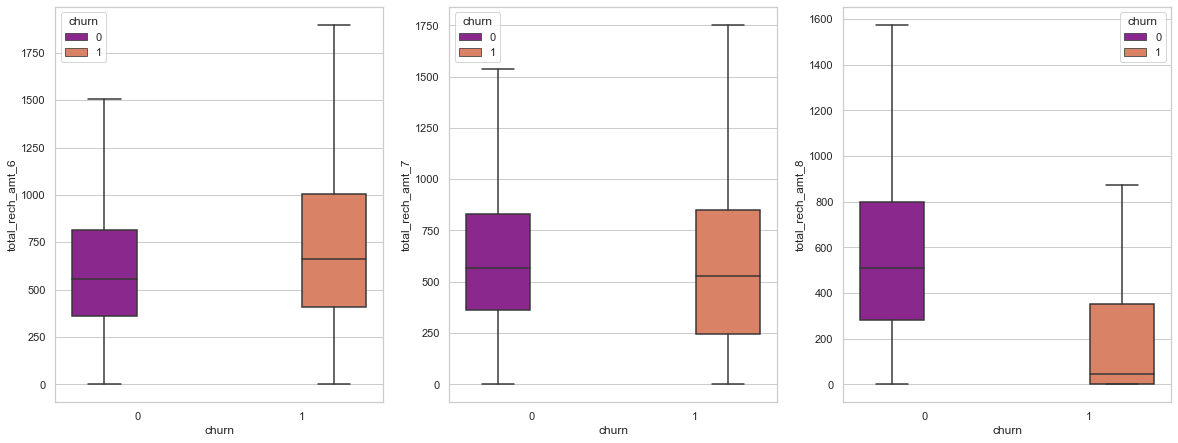

In [44]:
# Ploting for total recharge amount:
plot_box_chart('total_rech_amt')

> **Analysis:** We can see a drop in the total recharge amount for churned customers in the 8th Month (Action Phase).

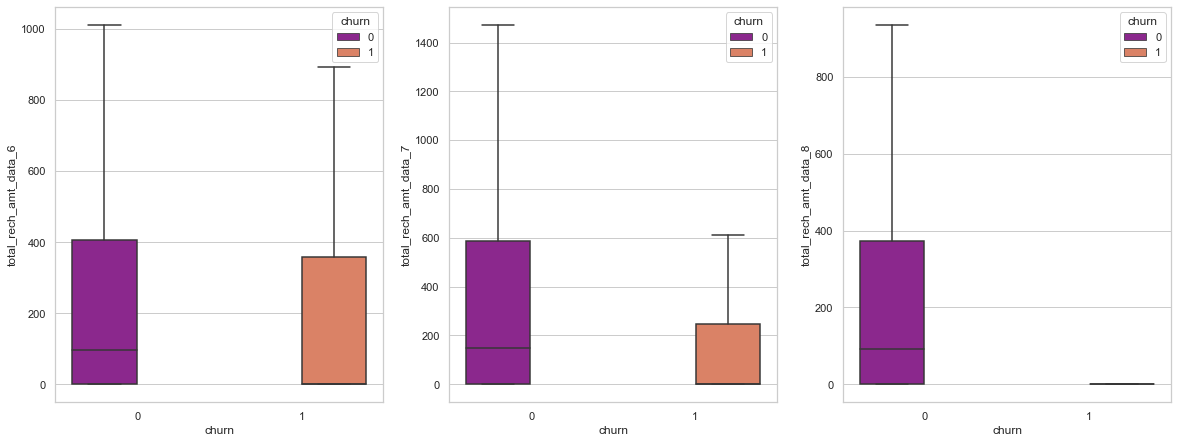

In [45]:
# Ploting for total recharge amount for data:
plot_box_chart('total_rech_amt_data')

**Analysis:** We can see that there is a huge drop in total recharge amount for data in the 8th month (action phase) for churned customers.

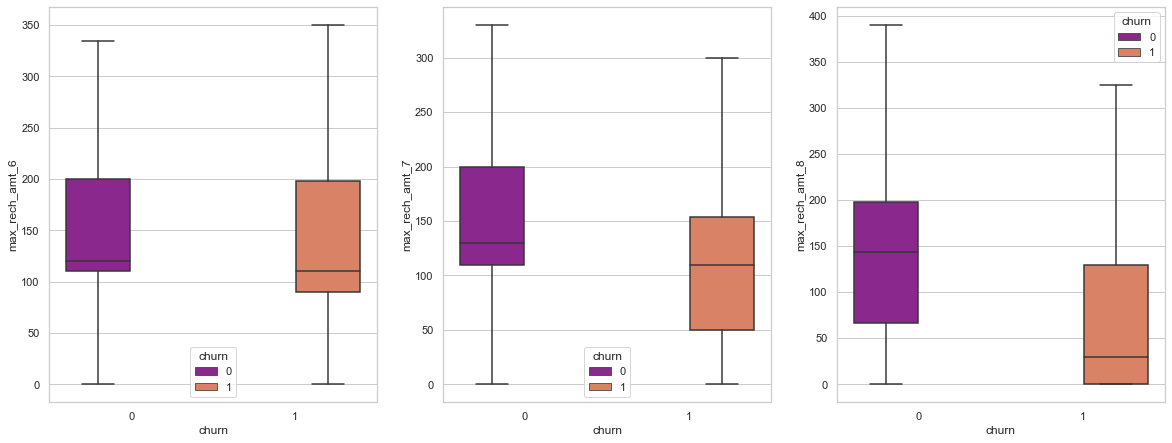

In [46]:
# Ploting for maximum recharge amount for data:
plot_box_chart('max_rech_amt')

**Analysis:** We can see that there is a huge drop in maximum recharge amount for data in the 8th month (action phase) for churned customers.

In [47]:
# Let's check other recharge related variables:
other_recharge = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('rech_num|max_rech_data',regex=True)]

In [48]:
# lets check the % of NA values for other recharge related variables
100*telecom_df_high_val_cust.loc[:,other_recharge].isnull().sum()/len(telecom_df_high_val_cust)

total_rech_num_6                   0.00
total_rech_num_7                   0.00
total_rech_num_8                   0.00
max_rech_data_6                   44.11
max_rech_data_7                   43.12
max_rech_data_8                   46.80
dtype: float64

In [49]:
telecom_df_high_val_cust.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].describe()

,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,"16,740.00","17,038.00","15,935.00"
mean,139.80,140.44,136.35
std,118.89,120.30,119.57
min,1.00,1.00,1.00
25%,25.00,25.00,25.00
50%,152.00,152.00,152.00
75%,198.00,198.00,198.00
max,"1,555.00","1,555.00","1,555.00"


**Analysis:** We see that the minimum value is 1 while the max is 1555 across months, which indicate the missing values are where no recharges happened for the data, Filling the missing values by 0 , means no recharge.

In [50]:
telecom_df_high_val_cust.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']] \
= telecom_df_high_val_cust.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].replace(np.nan,0)

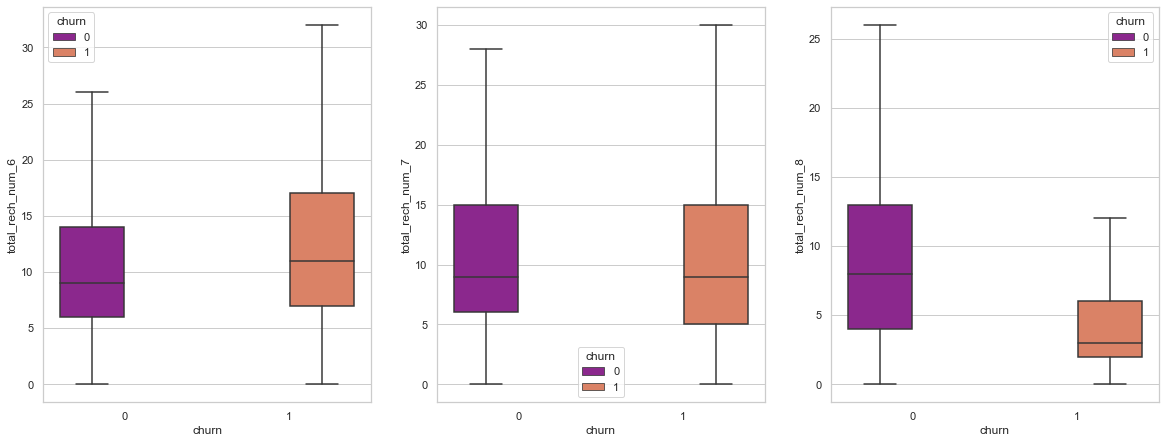

In [51]:
# Ploting for Total recharge for Number:
plot_box_chart('total_rech_num')

**Analysis:** We can see that there is a huge drop in total recharge number also in the 8th month (action phase) for churned customers.

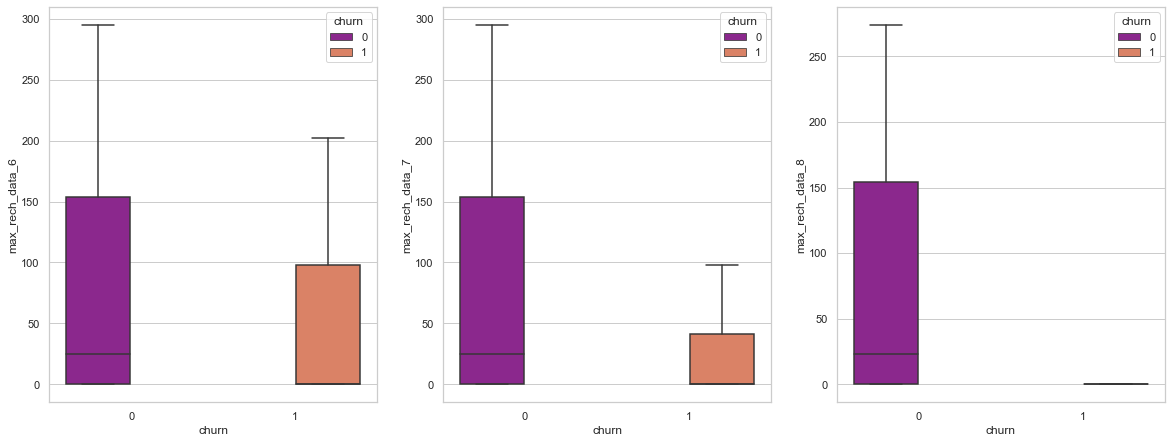

In [52]:
# Ploting for maximum recharge for data:
plot_box_chart('max_rech_data')

**Analysis:** We can see that there is a huge drop in maximum recharge for data also in the 8th month (action phase) for churned customers.

In [53]:
#Getting the last day recharge amount columns
last_day_rech_amt = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('day')]

In [54]:
last_day_rech_amt.tolist()

['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8']

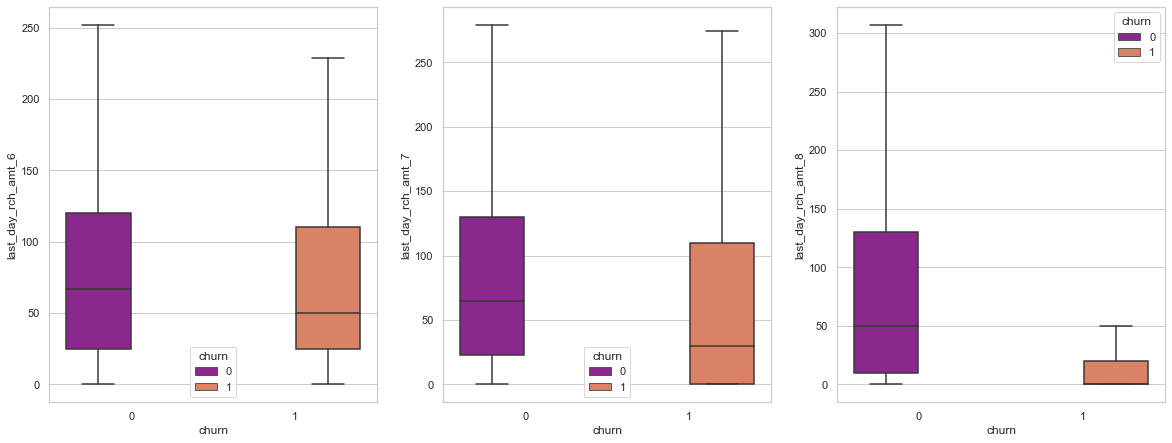

In [55]:
# Ploting for last day recharge amount:
plot_box_chart('last_day_rch_amt')

**Analysis:** We are getting a huge drop in 8th month recharge amount for churned customers.

#### 2G and 3G usage related attributes

In [56]:
usage_2g_and_3g = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('2g|3g',regex=True)]

In [57]:
#let us check the % of NA values present
percentage_3g_2g_null_check = 100*telecom_df_high_val_cust.loc[:,usage_2g_and_3g].isnull().sum()/len(telecom_df_high_val_cust.loc[:,usage_2g_and_3g])
df = pd.DataFrame(percentage_3g_2g_null_check)
df.rename(columns={0:'Null_Percentage'}, inplace=True)
df = pd.DataFrame(df.Null_Percentage).style.applymap(color_red)
display(df)

,Null_Percentage
count_rech_2g_6,44.112443
count_rech_2g_7,43.117551
count_rech_2g_8,46.799987
count_rech_3g_6,44.112443
count_rech_3g_7,43.117551
count_rech_3g_8,46.799987
vol_2g_mb_6,0.000000
vol_2g_mb_7,0.000000
vol_2g_mb_8,0.000000
vol_3g_mb_6,0.000000


**Analysis:** We are getting more then 40% values are not available for count of recharge and average revenue for 2G/3G per user. Although we have 2G/3G volume usage based data available, we can drop these columns.

In [58]:
telecom_df_high_val_cust.drop(['count_rech_2g_6','count_rech_2g_7',
              'count_rech_2g_8','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8'
               ,'arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8'],axis=1,inplace=True)

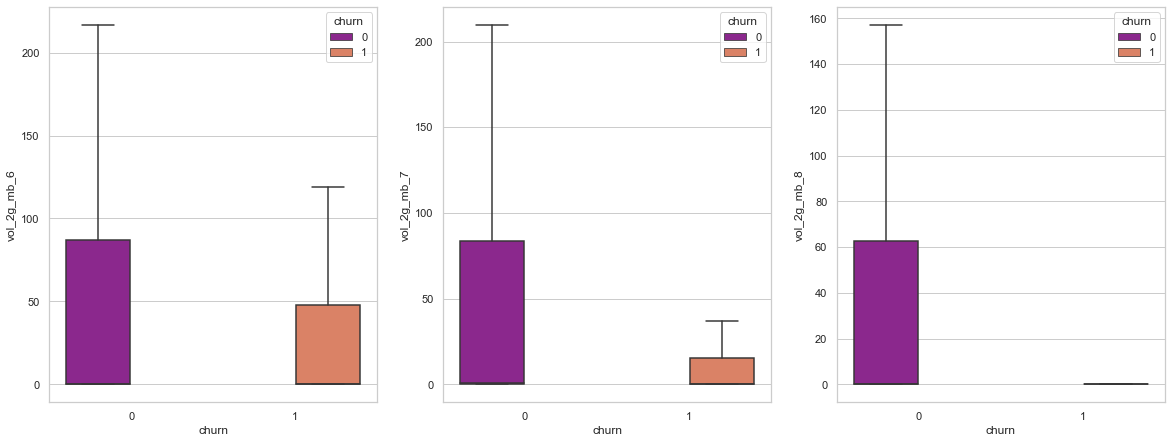

In [59]:
# Ploting for volume of 2G and 3G usage columns:
plot_box_chart('vol_2g_mb')

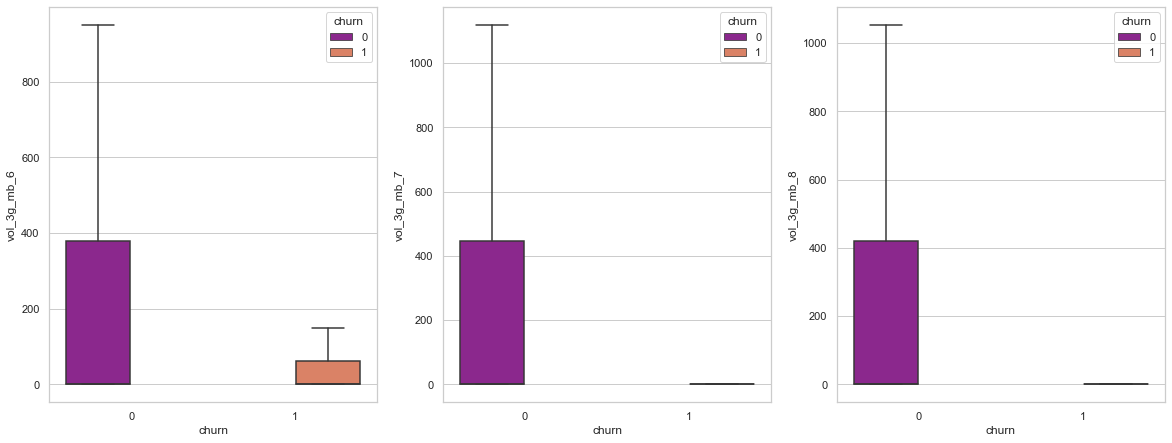

In [60]:
plot_box_chart('vol_3g_mb')

**Analysis:** We have two observations from above:

* 2G and 3G usage for churned customers drops in 8th month
* We also see that 2G/3G usage is higher for non-churned customers indicating that churned customers might be from areas where 2G/3G service is not properly available.

In [61]:
# let's check monthly 2G/3G service schemes
monthly_subcription_2g_3g = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('monthly_2g|monthly_3g',regex=True)]
monthly_subcription_2g_3g.tolist()

['monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8']

In [62]:
#Checking Null value
#100*telecom_df_high_val_cust.loc[:,monthly_subcription_2g_3g].isnull().sum()/len(telecom_df_high_val_cust.loc[:,monthly_subcription_2g_3g])

In [63]:
telecom_df_high_val_cust[monthly_subcription_2g_3g].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   monthly_2g_6  29953 non-null  int64
 1   monthly_2g_7  29953 non-null  int64
 2   monthly_2g_8  29953 non-null  int64
 3   monthly_3g_6  29953 non-null  int64
 4   monthly_3g_7  29953 non-null  int64
 5   monthly_3g_8  29953 non-null  int64
dtypes: int64(6)
memory usage: 1.6 MB


In [64]:
telecom_df_high_val_cust[monthly_subcription_2g_3g].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   monthly_2g_6  29953 non-null  int64
 1   monthly_2g_7  29953 non-null  int64
 2   monthly_2g_8  29953 non-null  int64
 3   monthly_3g_6  29953 non-null  int64
 4   monthly_3g_7  29953 non-null  int64
 5   monthly_3g_8  29953 non-null  int64
dtypes: int64(6)
memory usage: 1.6 MB


**Analysis:** Value range is very low, hence graph is not giving us proper justification result .Hence doing analysis by checking mean value.

In [65]:
def plot_mean_bar_chart(df,columns_list):
    df_0 = df[df.churn==0].filter(columns_list)
    df_1 = df[df.churn==1].filter(columns_list)

    mean_df_0 = pd.DataFrame([df_0.mean()],index={'Non Churn'})
    mean_df_1 = pd.DataFrame([df_1.mean()],index={'Churn'})

    frames = [mean_df_0, mean_df_1]
    mean_bar = pd.concat(frames)

    mean_bar.T.plot.bar(figsize=(10,5),rot=0)
    plt.show()
    
    return mean_bar

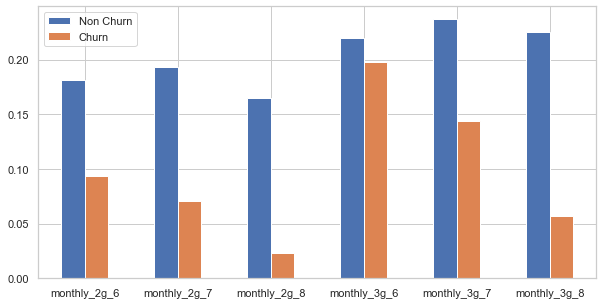

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
Non Churn,0.18,0.19,0.17,0.22,0.24,0.22
Churn,0.09,0.07,0.02,0.20,0.14,0.06


In [66]:
plot_mean_bar_chart(telecom_df_high_val_cust, monthly_subcription_2g_3g)

**Analysis:** Again we can see a drop in monthly subscription for churned customers in 8th Month.

In [67]:
# let's check Volume based cost 
vbc_column = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('vbc_',regex=True)]
vbc_column.tolist()

['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g']

In [68]:
# Renaming month named vbc columns to 6,7,8,9 format
telecom_df_high_val_cust.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'
                         ,'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

# drop 9th month column as it is not needed
telecom_df_high_val_cust.drop('vbc_3g_9',axis=1,inplace=True)

In [69]:
vbc_column = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('vbc_3g',regex=True)]
vbc_column.tolist()

['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6']

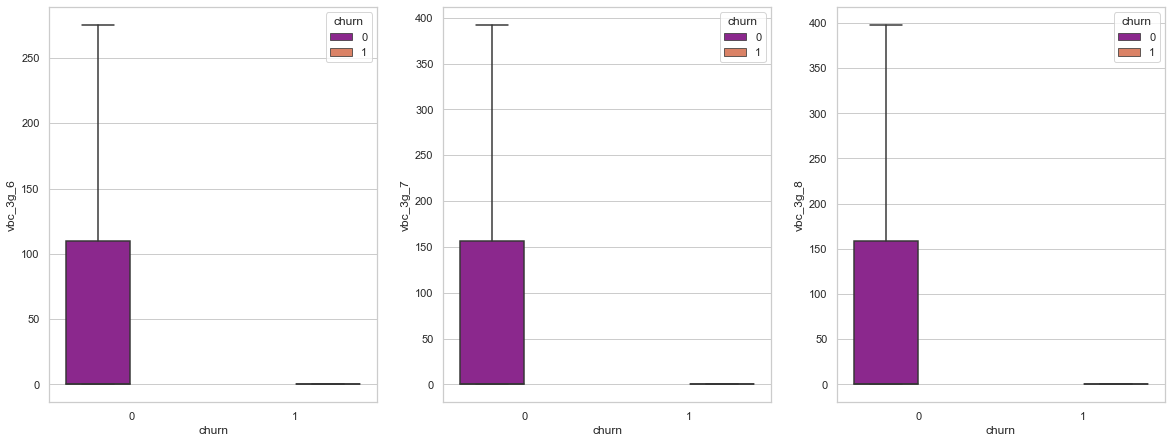

In [70]:
# Ploting for volume based cost :
plot_box_chart('vbc_3g')

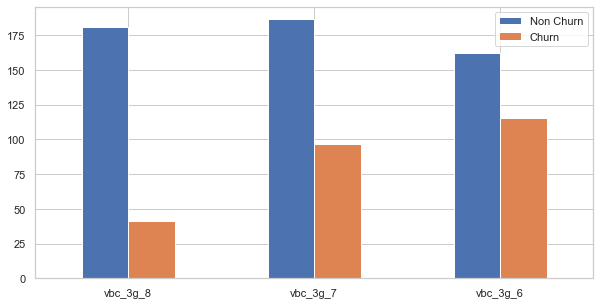

,vbc_3g_8,vbc_3g_7,vbc_3g_6
Non Churn,180.62,186.37,162.56
Churn,40.94,96.34,115.46


In [71]:
plot_mean_bar_chart(telecom_df_high_val_cust, vbc_column)

**Analysis:** Significantly it showing that volume based cost for 3G is much lower for Churned customers as compared to Non-Churned Customers and also there is a drop in vbc in 8th month

In [72]:
# Checking Service schemes with validity smaller than a month for 2G/3G
SC_2g_or_3g_col = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('sachet_2g|sachet_3g',regex=True)]

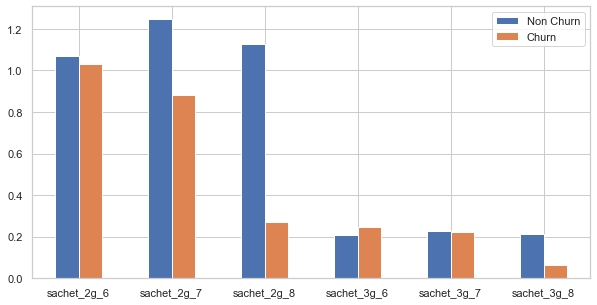

,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8
Non Churn,1.07,1.25,1.13,0.21,0.23,0.21
Churn,1.03,0.88,0.27,0.24,0.22,0.07


In [73]:
plot_mean_bar_chart(telecom_df_high_val_cust, SC_2g_or_3g_col)

**Analysis:** We can see the drop in sachet services in 8th month for churned cutsomers

####  Average Revenue Per User

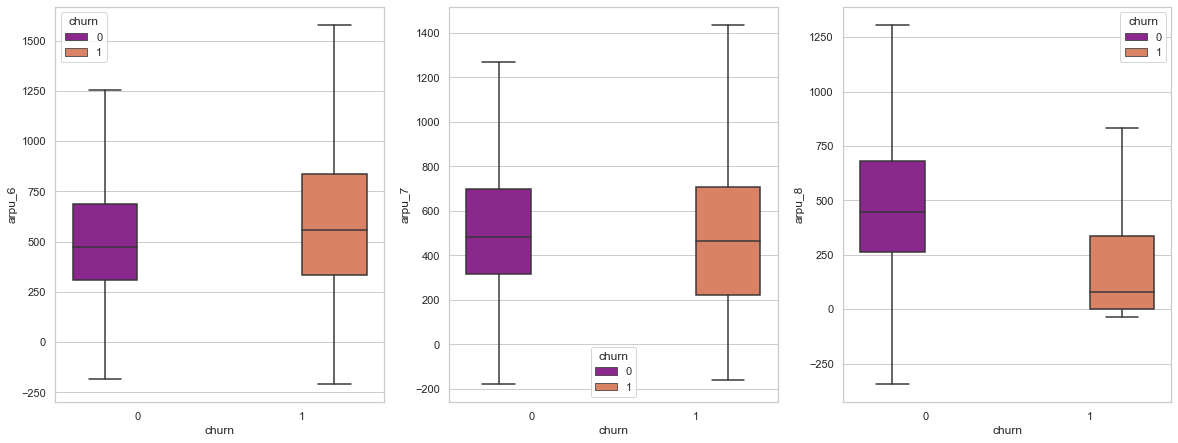

In [74]:
# Checking columns for average revenue per user
arpu_cols = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('arpu_')]

# Plotting arpu
plot_box_chart('arpu')

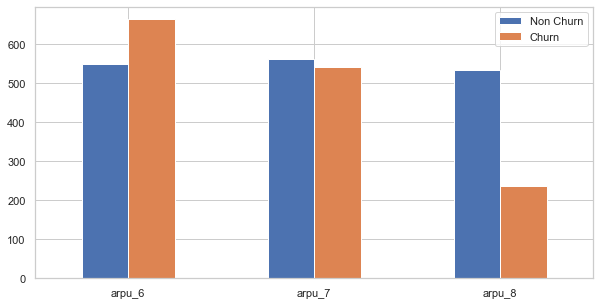

,arpu_6,arpu_7,arpu_8
Non Churn,549.55,562.93,532.87
Churn,663.71,541.15,237.66


In [75]:
plot_mean_bar_chart(telecom_df_high_val_cust, arpu_cols)

**Analysis:** We can see that huge drops for Arpu in 8th month for churned customers

 #### Minutes of usage - voice calls

In [76]:
mou_cols = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('mou')]

In [77]:
mou_cols


Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'total_og_mou_6',
       'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mo

In [78]:
meta_df = get_meta_data(telecom_df_high_val_cust[mou_cols])
meta_df.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
col_to_display = ['Null_Percentage']
meta_df[col_to_display]

,Null_Percentage
isd_ic_mou_8,3.91
loc_ic_t2t_mou_8,3.91
loc_ic_t2m_mou_8,3.91
std_og_t2t_mou_8,3.91
loc_og_t2c_mou_8,3.91
...,...
total_ic_mou_6,0.00
total_ic_mou_7,0.00
total_ic_mou_8,0.00
total_og_mou_6,0.00


**Analysis:** So for all minutes of usage columns the maximum missing % is 3.91 , means in these case the customer has not been used at all for that particular call type, thus we can fill the missing values with zero

In [79]:
# replaceing null values by 0 for minutes of usage variables
telecom_df_high_val_cust.loc[:,mou_cols] = telecom_df_high_val_cust.loc[:,mou_cols].replace(np.NaN,0)

In [80]:
mou_og_cols6 = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('.*_og_.*mou_6',regex=True)]

In [81]:
telecom_df_high_val_cust.loc[:,mou_og_cols6].describe()

,roam_og_mou_6,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_mou_6,isd_og_mou_6,spl_og_mou_6,total_og_mou_6
count,"29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00"
mean,26.60,84.57,163.31,6.35,1.58,254.24,165.90,179.44,1.81,347.15,2.17,5.83,610.06
std,116.27,228.96,250.22,22.14,6.31,378.55,403.99,409.14,11.99,608.85,45.89,17.58,691.18
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,4.38,19.21,0.00,0.00,32.26,0.00,0.00,0.00,0.40,0.00,0.00,116.64
50%,0.00,24.36,77.26,0.00,0.00,124.59,2.71,16.36,0.00,45.08,0.00,0.23,410.63
75%,0.00,78.06,209.03,4.23,0.00,332.31,109.56,154.54,0.00,465.29,0.00,5.21,859.03
max,"3,775.11","6,431.33","4,729.74","1,466.03",271.44,"10,643.38","7,366.58","8,314.76",628.56,"8,432.99","5,900.66","1,023.21","10,674.03"


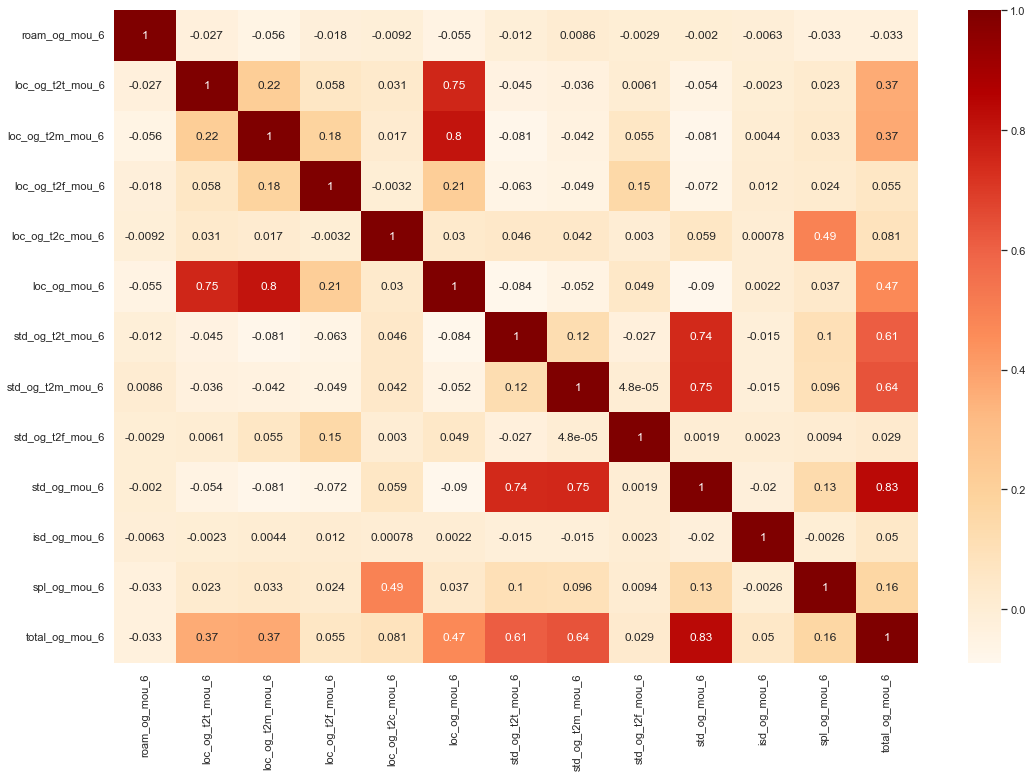

In [82]:
heatmap(18,12,telecom_df_high_val_cust.filter(mou_og_cols6))

**Analysis:** We can see that total_og_mou_6, std_og_mou_6 and loc_og_mou_6 seems to have strong correlation with other fileds and they needs to be inspected to avoid any multicolinearity issues.

In [83]:
print(telecom_df_high_val_cust.loc[8,'total_og_mou_6'],"==",telecom_df_high_val_cust.loc[8,['loc_og_mou_6','std_og_mou_6','spl_og_mou_6','isd_og_mou_6','og_others_6']].sum())
#print(telecom_df_high_val_cust.loc[8,'std_og_mou_6'],"==",telecom_df_high_val_cust.loc[8,['std_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2f_mou_6','std_og_loc_mou_6']].sum())
#print(telecom_df_high_val_cust.loc[8,'loc_og_mou_6'],"==",telecom_df_high_val_cust.loc[8,['loc_og_t2m_mou_6','loc_og_t2t_mou_6','loc_og_t2f_mou_6','loc_og_2tc_mou_6']].sum())

508.36 == 508.34999999999997


Analysis: We can see that total_og_mou_6, std_og_mou_6 and loc_og_mou_6 is a combination of other variables present in dataset.So we can remove these columns for all months from the data set

In [84]:
list_total_og_cols = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('total_og_mou|std_og_mou|loc_og_mou',regex=True)]
telecom_df_high_val_cust.drop(list_total_og_cols,axis=1,inplace=True)
log("Columns dropped - ")
list_total_og_cols.tolist()

> <span style='color:blue'>Columns dropped - </span>

['loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8']

#### Checking for incoming mou variables

In [85]:
mou_ic_cols6 = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('.*_ic_.*mou_6',regex=True)]


In [86]:
telecom_df_high_val_cust.loc[:,mou_ic_cols6].describe()

,roam_ic_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_mou_6,total_ic_mou_6,spl_ic_mou_6,isd_ic_mou_6
count,"29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00"
mean,16.12,65.51,150.47,15.29,231.28,14.90,29.21,2.70,46.81,290.12,0.06,10.80
std,76.34,163.86,219.32,45.79,315.01,77.75,98.28,19.11,137.60,365.74,0.19,76.79
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,6.10,28.09,0.00,47.91,0.00,0.00,0.00,1.03,72.89,0.00,0.00
50%,0.00,25.08,84.11,1.84,134.56,0.38,5.00,0.00,11.41,183.78,0.00,0.00
75%,0.00,67.48,188.74,11.98,297.26,8.19,23.63,0.11,41.49,372.16,0.00,0.00
max,"2,613.31","6,351.44","4,693.86","1,678.41","7,454.63","5,459.56","4,630.23","1,351.11","5,459.63","7,716.14",19.76,"6,789.41"


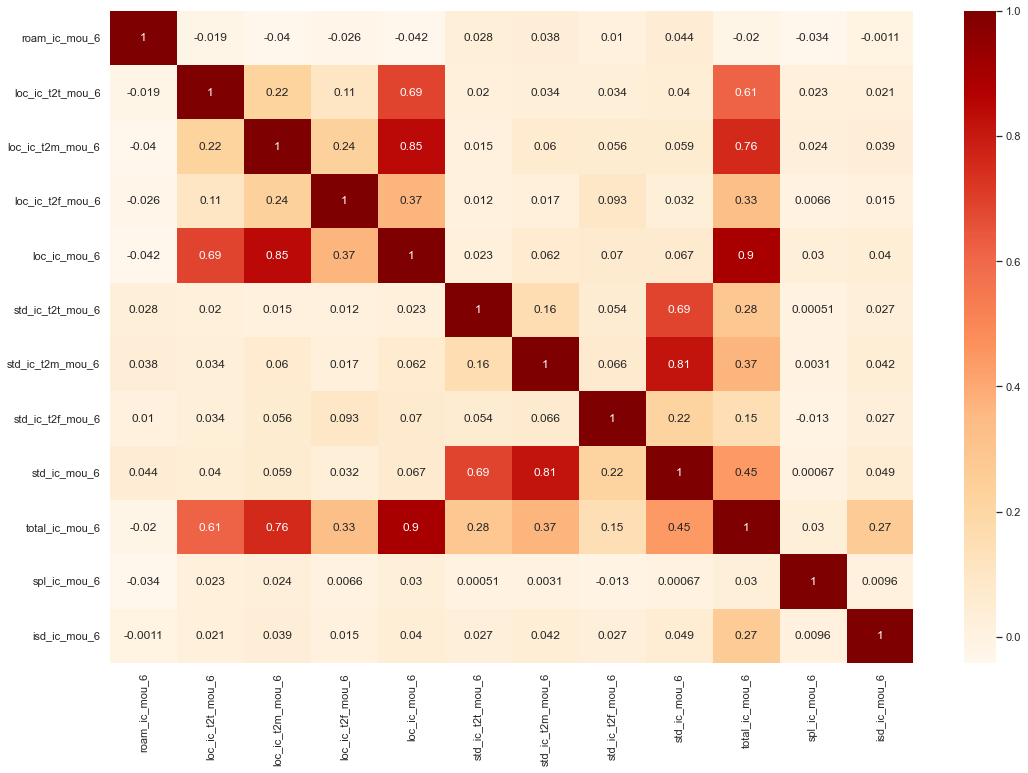

In [87]:
heatmap(18,12,telecom_df_high_val_cust.filter(mou_ic_cols6))

**Analysis:** We can see that total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 seems to have strong correlation with other fileds and they needs to be inspected to avoid any multicolinearity issues.

In [88]:
print(telecom_df_high_val_cust.loc[21,'total_ic_mou_6'],"==",telecom_df_high_val_cust.loc[21,['loc_ic_mou_6','roam_ic_mou_6','isd_ic_mou_6','spl_ic_mou_6','std_ic_mou_6']].sum())
#print(telecom_df_high_val_cust.loc[21,'loc_ic_mou_6'],"==",telecom_df_high_val_cust.loc[21,['loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','loc_ic_t2c_mou_6']].sum())
#print(telecom_df_high_val_cust.loc[21,'std_ic_mou_6'],"==",telecom_df_high_val_cust.loc[21,['std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6','std_ic_t2c_mou_6']].sum())

207.09 == 207.09


Analysis: We can see that total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 is a combination of other variables present in dataset.So we can remove these columns for all months from the data set

In [89]:
list_total_ic_cols = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('total_ic_mou|std_ic_mou|loc_ic_mou',regex=True)]
telecom_df_high_val_cust.drop(list_total_ic_cols,axis=1,inplace=True)
log("Columns dropped - ")
list_total_ic_cols.tolist()

> <span style='color:blue'>Columns dropped - </span>

['loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'std_ic_mou_6',
 'std_ic_mou_7',
 'std_ic_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8']

#### Offnet Usag

In [90]:
offnet_usage_service_col = telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('offnet.*mou',regex=True)]

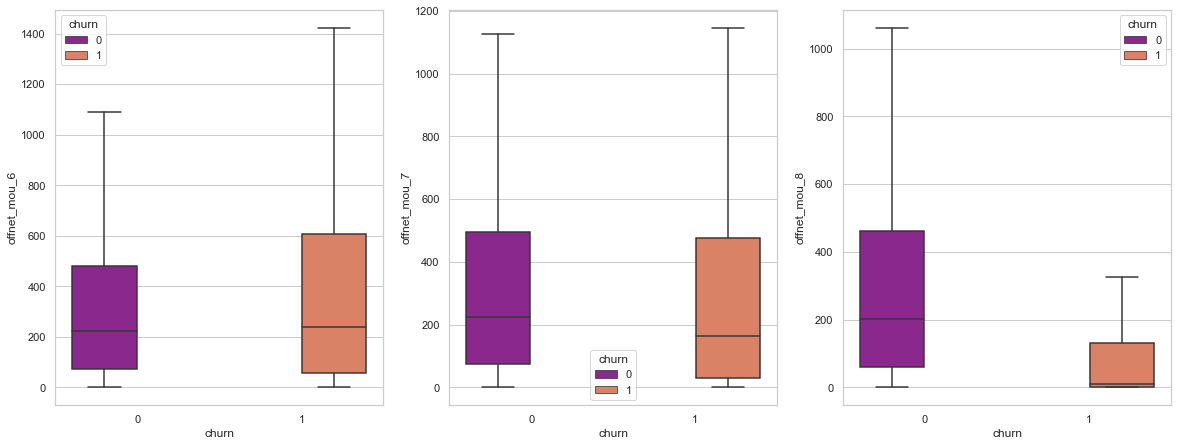

In [91]:
# Offnet mou values for churned and non churned customers
plot_box_chart('offnet_mou')

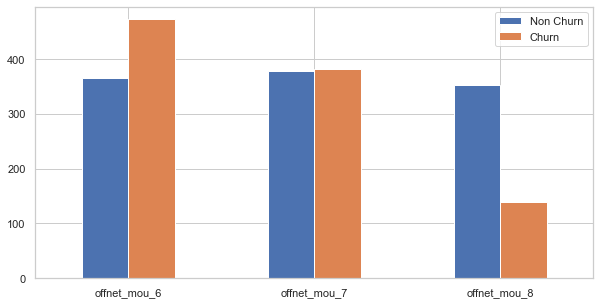

,offnet_mou_6,offnet_mou_7,offnet_mou_8
Non Churn,365.12,377.88,352.50
Churn,471.95,382.28,138.52


In [92]:
plot_mean_bar_chart(telecom_df_high_val_cust, offnet_usage_service_col)

**Analysis:** We can see the drop for offnet mou services in the 8th month

####  ONNET : All kind of calls within the same operator network

In [93]:
#minutes of usage related columns
onnet_usage_service =  telecom_df_high_val_cust.columns[telecom_df_high_val_cust.columns.str.contains('^onnet.*mou',regex=True)]

In [94]:
onnet_usage_service

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8'], dtype='object')

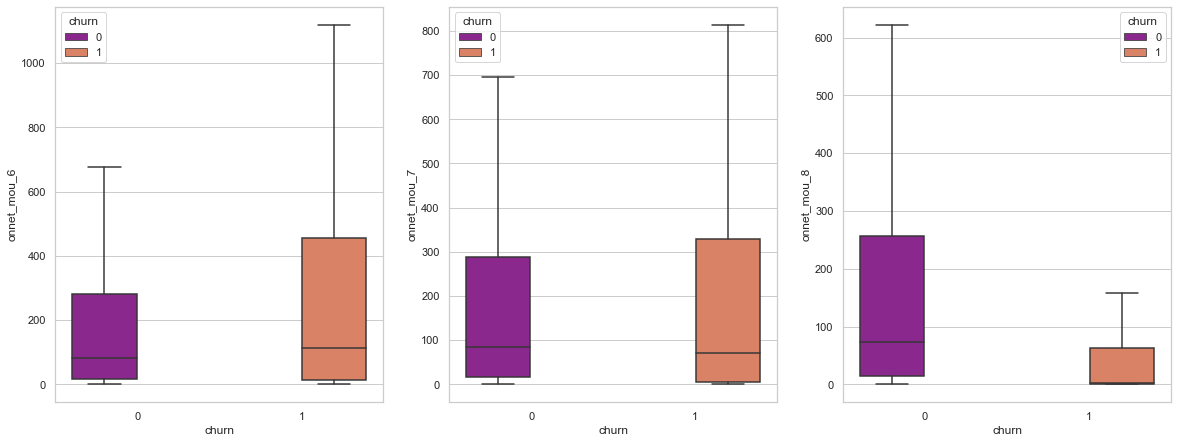

In [95]:
# Plotting offnet
plot_box_chart('onnet_mou')

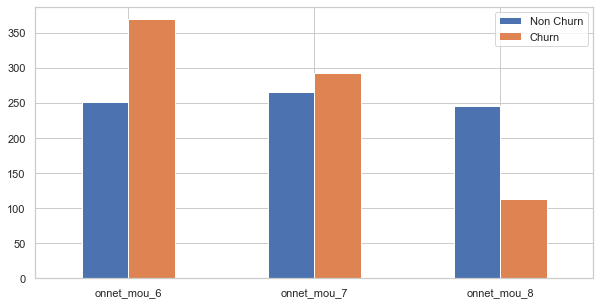

,onnet_mou_6,onnet_mou_7,onnet_mou_8
Non Churn,251.37,265.86,245.03
Churn,368.66,292.85,113.48


In [96]:
plot_mean_bar_chart(telecom_df_high_val_cust, onnet_usage_service)

**Analysis:** We also see that there is a drop in Onnet usage in the 8th month for churned customers

#### Tenure Analysis for Customers

In [97]:
tenure_data = telecom_df_high_val_cust.copy()

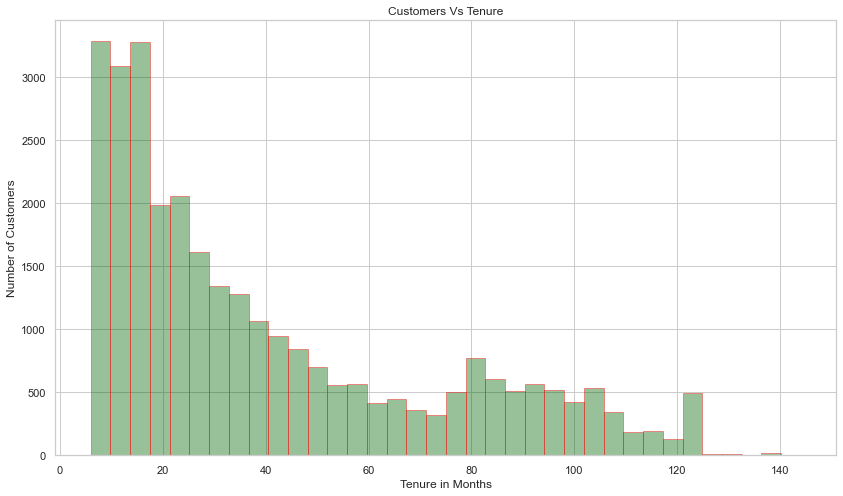

In [98]:
plt.figure(figsize=(14,8))
# aon --> Age on network - number of days the customer is using the operator T network
tenure_data['tenure'] = tenure_data['aon']/30
tenure_data['tenure'].head()
ax = sns.distplot(tenure_data['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkgreen', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Tenure in Months')
ax.set_title('Customers Vs Tenure')
plt.show()

In [99]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
tenure_data['tenure_range'] = pd.cut(tenure_data['tenure'], tn_range, labels=tn_label)
tenure_data['tenure_range'].head()

0     2-5 Yrs    
7     2-5 Yrs    
8     6-12 Months
21    1-2 Yrs    
23    1-2 Yrs    
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

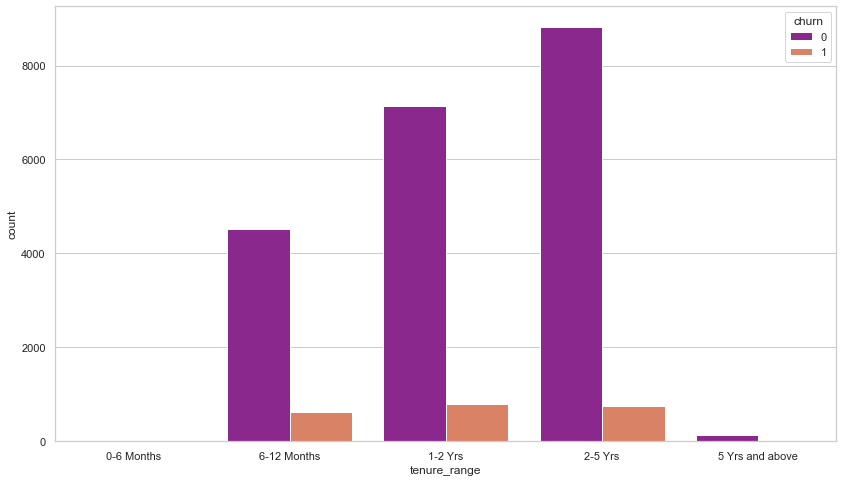

In [100]:
plt.figure(figsize=(14,8))
sns.countplot(x = 'tenure_range', hue = 'churn',data = tenure_data,palette=("plasma"))
plt.show()

#### Checking columns with more than 30% NA values.

In [101]:
meta_df = get_meta_data(telecom_df_high_val_cust)
meta_df = meta_df[meta_df["Null_Percentage"] > 30]
meta_df.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
col_to_display = ['Null_Percentage']
meta_df[col_to_display]

,Null_Percentage
date_of_last_rech_data_8,46.80
night_pck_user_8,46.80
fb_user_8,46.80
date_of_last_rech_data_6,44.11
night_pck_user_6,44.11
fb_user_6,44.11
date_of_last_rech_data_7,43.12
night_pck_user_7,43.12
fb_user_7,43.12


In [102]:
#Dropping 30% column
is_more_30 = meta_df.index
telecom_df_high_val_cust.drop(telecom_df_high_val_cust[is_more_30],axis=1,inplace=True)

In [103]:
telecom_df_high_val_cust.shape

(29953, 124)

#### Replacing NAN values

In [104]:
meta_df = get_meta_data(telecom_df_high_val_cust)
meta_df = meta_df[meta_df["Null_Percentage"] > 0]
meta_df.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
col_to_display = ['Null_Percentage']
meta_df[col_to_display]

,Null_Percentage
og_others_8,3.91
ic_others_8,3.91
date_of_last_rech_8,1.94
og_others_6,1.81
ic_others_6,1.81
og_others_7,1.79
ic_others_7,1.79
date_of_last_rech_7,0.33
date_of_last_rech_6,0.24


In [105]:
telecom_df_high_val_cust[meta_df.index].head(3)

,og_others_8,ic_others_8,date_of_last_rech_8,og_others_6,ic_others_6,og_others_7,ic_others_7,date_of_last_rech_7,date_of_last_rech_6
0,0.00,0.00,2014-08-08,NaN,NaN,NaN,NaN,2014-07-16,2014-06-21
7,0.00,15.14,2014-08-26,0.00,15.74,0.00,15.19,2014-07-25,2014-06-27
8,0.00,0.00,2014-08-30,0.00,0.00,0.00,0.00,2014-07-31,2014-06-25


#### Exploring/Imputing Numeric field

In [106]:
numberic_col = ['og_others_8', 'ic_others_8', 'og_others_6','ic_others_6', 'og_others_7', 'ic_others_7']

* Replacing NaN values with zero for all numeric data as most of the data is clean and will not impact the analysis

In [107]:
for i in numberic_col:
    telecom_df_high_val_cust.loc[telecom_df_high_val_cust[i].isnull(),i]=0


In [108]:
telecom_df_high_val_cust[meta_df.index].head(3)

,og_others_8,ic_others_8,date_of_last_rech_8,og_others_6,ic_others_6,og_others_7,ic_others_7,date_of_last_rech_7,date_of_last_rech_6
0,0.00,0.00,2014-08-08,0.00,0.00,0.00,0.00,2014-07-16,2014-06-21
7,0.00,15.14,2014-08-26,0.00,15.74,0.00,15.19,2014-07-25,2014-06-27
8,0.00,0.00,2014-08-30,0.00,0.00,0.00,0.00,2014-07-31,2014-06-25


In [109]:
meta_df = get_meta_data(telecom_df_high_val_cust)
meta_df = meta_df[meta_df["Null_Percentage"] > 0]
meta_df.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
col_to_display = ['Null_Percentage']
meta_df[col_to_display]

,Null_Percentage
date_of_last_rech_8,1.94
date_of_last_rech_7,0.33
date_of_last_rech_6,0.24


### Derive new features

In [110]:
telecom_df_final = telecom_df_high_val_cust.copy()
print(telecom_df_final.shape)
telecom_df_final.head(3)

(29953, 124)


,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,...,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
0,7000842753,197.38,214.82,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.00,...,3,2,362,252,252,252,252,252,2014-06-21,2014-07-16,2014-08-08,252,252,252,1.00,1.00,1.00,252.00,252.00,252.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,0,0,0,0,0,0,1,1,1,0,0,0,968,30.40,0.00,101.20,252.00,252.00,252.00,559.00,1
7,7000701601,"1,069.18","1,349.85","3,171.48",57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.00,0.18,10.01,4.50,0.00,6.50,0.00,0.00,0.00,58.14,32.26,27.31,217.56,...,5,7,1580,790,3638,1580,790,1580,2014-06-27,2014-07-25,2014-08-26,0,0,779,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,0.00,0.00,0.00,"1,185.00",1
8,7001524846,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.23,0.00,0.00,0.00,23.84,9.84,0.31,57.58,...,21,14,437,601,120,90,154,30,2014-06-25,2014-07-31,2014-08-30,50,0,10,0.00,2.00,3.00,0.00,154.00,23.00,0.00,177.00,69.00,0.00,356.00,0.03,0.00,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0.00,354.00,207.00,696.00,0


In [111]:
telecom_df_final.drop(["total_avg_rech_amnt_6_7_GPhase"],axis=1,inplace=True)
telecom_df_final.drop(telecom_df_high_val_cust.filter(regex='date_').columns,axis=1,inplace=True)
print (telecom_df_final.shape)

col_list = telecom_df_final.filter(regex='_6|_7').columns.str[:-2]
for idx, col in enumerate(col_list.unique()):
    print(col)
    avg_col_name = "avg_"+col+"_av67"
    col_6 = col+"_6"
    col_7 = col+"_7"
    telecom_df_final[avg_col_name] = (telecom_df_final[col_6]  + telecom_df_final[col_7])/ 2

(29953, 120)
arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2t_mou
loc_og_t2m_mou
loc_og_t2f_mou
loc_og_t2c_mou
std_og_t2t_mou
std_og_t2m_mou
std_og_t2f_mou
isd_og_mou
spl_og_mou
og_others
loc_ic_t2t_mou
loc_ic_t2m_mou
loc_ic_t2f_mou
std_ic_t2t_mou
std_ic_t2m_mou
std_ic_t2f_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
total_rech_amt
max_rech_amt
last_day_rch_amt
total_rech_data
max_rech_data
av_rech_amt_data
vol_2g_mb
vol_3g_mb
monthly_2g
sachet_2g
monthly_3g
sachet_3g
vbc_3g
total_rech_amt_data


In [112]:
col_list_to_drop = telecom_df_final.filter(regex='_6|_7')
telecom_df_final.drop(col_list_to_drop,axis=1,inplace=True)
print (telecom_df_final.shape)

(29953, 81)


In [113]:
telecom_df_final.head(3)

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,churn,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
0,7000842753,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,4.13,1.15,0.00,0.00,0.00,0.00,0.00,0.00,2,252,252,252,1.00,252.00,252.00,5.75,109.61,0,0,1,0,968,30.40,252.00,1,206.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,307.00,252.00,252.00,1.00,252.00,252.00,15.72,117.16,0.00,0.00,1.00,0.00,50.60,252.00
7,7000701601,"3,171.48",52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,12.01,49.14,16.68,10.01,6.50,0.00,27.31,121.19,39.53,30.39,141.33,22.21,0.00,31.59,15.14,7,3638,1580,779,0.00,0.00,0.00,0.00,0.00,0,0,0,0,802,57.74,0.00,1,"1,209.51",56.26,510.29,24.86,18.16,41.38,378.00,58.64,0.00,13.79,40.83,13.37,0.09,2.25,0.00,45.20,219.53,126.81,24.36,109.22,43.22,0.10,8.29,15.46,5.00,"1,185.00","1,185.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,0.00
8,7001524846,137.36,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,22.58,75.69,0.00,0.00,10.23,0.00,0.31,15.48,0.00,0.10,0.65,0.00,0.00,0.00,0.00,14,120,30,10,3.00,23.00,69.00,0.03,11.94,0,3,0,0,315,21.03,207.00,0,435.47,382.36,87.64,0.00,0.00,257.36,75.77,0.00,0.00,125.00,11.86,0.00,0.00,0.00,0.00,16.84,35.78,0.00,0.29,13.25,0.00,0.00,0.00,0.00,20.00,519.00,122.00,25.00,1.00,77.00,88.50,178.00,375.48,0.50,0.50,0.00,0.00,516.40,177.00


**Analysis:** We have merged most of the columns related to month 6 & 7 so to reduce the number of features. By doing this apporach we have reduced the fetures from 124 to 81.

## Modelling

### PCA : Principal Component Analysis

In [114]:
telecom_pca_df = telecom_df_final.copy()

In [115]:
# check version number
import imblearn
print(imblearn.__version__)

0.10.1


In [116]:
def split_date(df):
    Y = df["churn"]
    X = df.drop(["churn","mobile_number"],axis=1)
    return X,Y
    
def scale_data(X):
    scaler = StandardScaler()
    X_col = X.columns
    X_scaled = scaler.fit_transform(X)
    X_scale_final = pd.DataFrame(X_scaled, columns=X_col)
    log("Scaling the data ....")
    return X_scale_final

In [117]:
def get_scree_plot(X):
    pca = PCA(svd_solver='randomized', random_state=101)
    pca.fit(X)
    fig = plt.figure(figsize = (8,6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()
    return pca
    
    
def resampling_data(X,Y,feature_number,train_size=0.7,test_size=0.3) :
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, train_size=train_size, random_state=1)

    log("Shape of train datatset before : "+str(x_train.shape))
    log("Percenatge of Churned customer data : "+str(round(100*Y.sum()/len(Y),2)))
    log("Applying SMOTE to normalize imbalance ....")

    #Initializing SMOTE: Synthetic Minority Over-sampling Technique
    # using this as data is skewed 
    smote = SMOTE(kind ='regular')
    x_tr,y_tr = smote.fit_sample(x_train,y_train)
    log("Shape of train datatset after SMOTE : "+str(x_tr.shape))

    # Applying PCA : Pricnipal Component Analysis
    pca = IncrementalPCA(n_components=feature_number)    
    x_tr_pca = pca.fit_transform(x_tr)
    x_test_pca = pca.transform(x_test)
    log("Shape of train datatset after PCA : "+str(x_tr_pca.shape))

    return x_tr_pca,x_test_pca,y_tr,y_test


In [118]:
X,Y=split_date(telecom_pca_df)

In [119]:
X.head(2)

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
0,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,4.13,1.15,0.00,0.00,0.00,0.00,0.00,0.00,2,252,252,252,1.00,252.00,252.00,5.75,109.61,0,0,1,0,968,30.40,252.00,206.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,307.00,252.00,252.00,1.00,252.00,252.00,15.72,117.16,0.00,0.00,1.00,0.00,50.60,252.00
7,"3,171.48",52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,12.01,49.14,16.68,10.01,6.50,0.00,27.31,121.19,39.53,30.39,141.33,22.21,0.00,31.59,15.14,7,3638,1580,779,0.00,0.00,0.00,0.00,0.00,0,0,0,0,802,57.74,0.00,"1,209.51",56.26,510.29,24.86,18.16,41.38,378.00,58.64,0.00,13.79,40.83,13.37,0.09,2.25,0.00,45.20,219.53,126.81,24.36,109.22,43.22,0.10,8.29,15.46,5.00,"1,185.00","1,185.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,0.00


In [120]:
Y.head(2)

0    1
7    1
Name: churn, dtype: int64

**Percentage distribution of churn/non-churn cutomer data**

In [121]:
log("Percenatge of Churned Customer data : "+str(round(100*Y.sum()/len(Y),2)))

> <span style='color:blue'>Percenatge of Churned Customer data : 8.12</span>

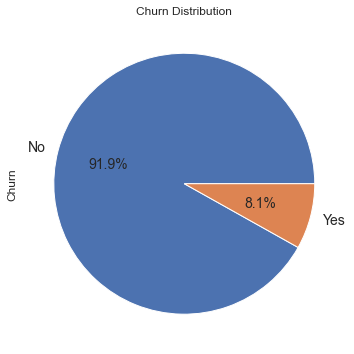

In [122]:
#Churn Distribution
pie_chart = telecom_pca_df['churn'].value_counts()*100.0 /len(telecom_pca_df)
ax = pie_chart.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(8,6), fontsize = 14 )                                                                           
ax.set_ylabel('Churn',fontsize = 12)
ax.set_title('Churn Distribution', fontsize = 12)
plt.show()

**Scaling the data so as to normalize all the fields**

In [123]:
X_scaled = scale_data(X)
print(X_scaled.shape)
X_scaled.head(5)

> <span style='color:blue'>Scaling the data ....</span>

(29953, 79)


,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
0,-0.59,-0.51,-0.70,-0.17,-0.19,-0.34,-0.65,-0.30,-0.24,-0.37,-0.38,-0.15,-0.04,-0.32,-0.02,-0.39,-0.66,-0.31,-0.19,-0.27,-0.13,-0.24,-0.16,-0.10,-0.86,-0.54,0.53,1.10,-0.21,1.62,0.66,-0.32,-0.26,-0.38,-0.42,1.28,-0.18,-0.25,-0.33,-0.13,-0.82,-0.60,-0.82,-0.22,-0.25,-0.38,-0.70,-0.30,-0.27,-0.44,-0.47,-0.16,-0.05,-0.37,-0.14,-0.42,-0.73,-0.35,-0.20,-0.32,-0.15,-0.27,-0.15,-0.10,-0.96,-0.69,0.53,1.30,-0.28,1.68,0.64,-0.37,-0.29,-0.46,-0.47,1.36,-0.23,-0.30,-0.19
1,5.30,-0.40,-0.02,0.26,0.17,-0.17,0.04,2.43,-0.24,-0.34,-0.26,1.38,0.18,-0.00,-0.02,-0.22,-0.12,0.58,0.23,1.10,0.99,-0.24,0.29,1.09,-0.32,4.99,8.19,4.73,-0.54,-0.66,-0.62,-0.34,-0.38,-0.38,-0.42,-0.34,-0.18,-0.43,-0.26,-0.29,1.51,-0.47,0.29,0.16,-0.06,-0.20,0.92,2.49,-0.27,-0.41,-0.36,1.00,-0.05,-0.24,-0.14,-0.13,0.33,2.50,0.12,0.84,2.26,0.43,-0.04,1.03,-0.79,1.02,6.57,-0.87,-0.65,-0.77,-0.74,-0.42,-0.43,-0.46,-0.47,-0.39,-0.23,-0.38,-0.40
2,-0.74,-0.43,-0.41,-0.17,-0.19,-0.29,-0.43,-0.30,0.76,-0.32,-0.20,-0.15,-0.04,0.18,-0.02,-0.39,-0.61,-0.33,-0.19,-0.26,-0.13,-0.24,-0.16,-0.10,0.43,-0.76,-0.75,-0.57,0.46,-0.45,-0.27,-0.34,-0.37,-0.38,0.77,-0.34,-0.18,-0.93,-0.35,-0.16,-0.29,0.27,-0.63,-0.22,-0.25,0.77,-0.38,-0.30,-0.27,-0.12,-0.44,-0.16,-0.05,-0.37,-0.14,-0.31,-0.56,-0.35,-0.20,-0.18,-0.15,-0.27,-0.15,-0.10,0.95,-0.28,-0.32,-0.65,-0.28,-0.02,-0.26,0.17,0.02,0.83,-0.27,-0.39,-0.23,0.88,-0.25
3,0.26,-0.33,1.35,-0.17,-0.19,-0.24,-0.20,-0.22,-0.24,-0.22,1.76,-0.15,-0.04,-0.32,-0.02,-0.27,-0.08,-0.09,-0.19,0.71,-0.13,-0.24,-0.16,-0.10,1.84,0.22,-0.64,-0.29,-0.54,-0.66,-0.62,-0.34,-0.38,-0.38,-0.42,-0.34,-0.18,-0.51,-0.40,-0.29,-0.01,-0.33,0.99,-0.22,-0.25,-0.36,-0.32,-0.29,-0.27,-0.15,1.40,-0.16,-0.05,-0.37,-0.14,-0.38,-0.26,-0.27,-0.07,0.24,-0.15,-0.27,-0.15,-0.10,1.41,-0.04,-0.78,-0.65,-0.65,-0.77,-0.74,-0.42,-0.43,-0.46,-0.47,-0.39,-0.23,-0.43,-0.40
4,-0.28,-0.44,-0.27,-0.17,-0.19,-0.20,-0.01,-0.30,2.24,-0.37,-0.29,-0.15,-0.04,0.55,-0.02,0.09,0.00,-0.32,-0.01,0.15,-0.13,-0.24,-0.10,0.93,-0.64,-0.24,0.11,-0.64,0.13,0.96,0.76,-0.34,0.72,-0.38,-0.42,1.28,0.72,-0.63,-0.31,0.05,-0.99,-0.49,-0.63,-0.22,-0.25,-0.16,-0.35,-0.30,-0.27,-0.44,-0.46,-0.16,-0.05,-0.37,-0.14,-0.16,-0.22,-0.35,-0.20,-0.23,-0.15,-0.27,0.04,0.10,-0.90,-0.84,-0.53,-0.10,-0.28,0.10,0.23,-0.42,-0.07,-0.46,-0.47,1.36,-0.23,-0.36,-0.11


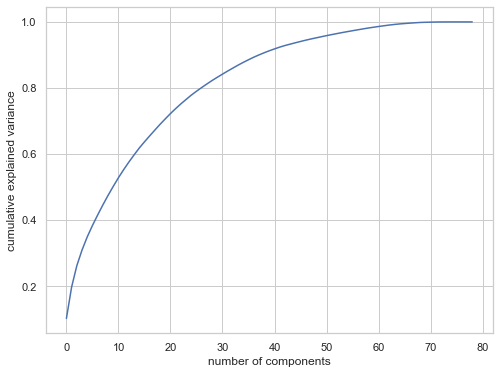

,PC1,PC2,PC3,Feature
0,0.00,0.29,0.15,arpu_8
1,-0.11,0.11,0.15,onnet_mou_8
2,-0.10,0.20,0.11,offnet_mou_8
3,-0.01,0.05,0.01,roam_ic_mou_8
4,-0.02,0.07,0.03,roam_og_mou_8
5,-0.03,0.10,0.02,loc_og_t2t_mou_8
6,-0.03,0.18,-0.03,loc_og_t2m_mou_8
7,0.01,0.11,-0.09,loc_og_t2f_mou_8
8,-0.01,0.02,0.08,loc_og_t2c_mou_8
9,-0.11,0.07,0.16,std_og_t2t_mou_8


In [124]:
pca = get_scree_plot(X_scaled) # scree plot

col = list(X_scaled.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head(10)

In [125]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 10.34,  19.83,  26.28,  31.01,  34.99,  38.42,  41.6 ,  44.64,
        47.53,  50.26,  52.88,  55.32,  57.61,  59.77,  61.85,  63.73,
        65.53,  67.3 ,  69.04,  70.69,  72.3 ,  73.81,  75.24,  76.57,
        77.88,  79.06,  80.18,  81.26,  82.3 ,  83.28,  84.23,  85.16,
        86.06,  86.95,  87.79,  88.58,  89.34,  90.04,  90.69,  91.3 ,
        91.86,  92.4 ,  92.88,  93.3 ,  93.71,  94.11,  94.5 ,  94.86,
        95.2 ,  95.54,  95.87,  96.18,  96.49,  96.79,  97.07,  97.35,
        97.63,  97.9 ,  98.16,  98.4 ,  98.63,  98.84,  99.05,  99.23,
        99.39,  99.52,  99.64,  99.75,  99.85,  99.9 ,  99.94,  99.98,
       100.  , 100.01, 100.01, 100.01, 100.01, 100.01, 100.01])

**Analysis:** Looks like 60 components are enough to describe 95% of the variance in the dataset.We'll choose 60 components for our modeling

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,Y,train_size = 0.7)
X_train.shape

(20967, 79)

In [127]:
X_train.shape

(20967, 79)

In [128]:
 #Defining a custom function to print model metrics
def print_model_metrics(y_test,y_pred,model_name):
    print('Model Stats Score Summary: ')
    cp = confusion_matrix(y_test,y_pred)
    plt.figure()
    confusion_matrix_plot(cp)
    plt.show()
    
    accuracy = round(accuracy_score(y_test,y_pred),2)
    recall = round(recall_score(y_test,y_pred),2)
    precision = round(precision_score(y_test,y_pred),2)
    auc = round(roc_auc_score(y_test,y_pred),2)
    f1 = round(f1_score(y_test,y_pred),2)
    
    data = [[model_name,accuracy,recall,precision,auc,f1]] 
    df = pd.DataFrame(data, columns = ['Model', 'Accuracy','Precision','Recall','AUC','F1'])
    add_to_global_summary(df)
    return df 

def confusion_matrix_plot(cm):
    classes=[0,1]
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

model_summary = pd.DataFrame()

def add_to_global_summary(df) :
    global model_summary 
    model_summary = model_summary.append(df,ignore_index=True)

### Logistic Regression Model

In [129]:
# Training the model
lr = LogisticRegression()
model = lr.fit(X_train,y_train)
#Making prediction on the test data
pred_probs_test = model.predict_proba(X_test)[:,1]

In [130]:
# Logistic Regression Accuracy
print('Accuracy:', metrics.roc_auc_score(y_test, pred_probs_test))

Accuracy: 0.9039274052245938


###  RandomForest Model

In [131]:
# Creating a backup copy
telecom_tree_df = telecom_df_final.copy()

In [132]:
telecom_tree_df.head()

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,churn,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
0,7000842753,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,4.13,1.15,0.00,0.00,0.00,0.00,0.00,0.00,2,252,252,252,1.00,252.00,252.00,5.75,109.61,0,0,1,0,968,30.40,252.00,1,206.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,307.00,252.00,252.00,1.00,252.00,252.00,15.72,117.16,0.00,0.00,1.00,0.00,50.60,252.00
7,7000701601,"3,171.48",52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,12.01,49.14,16.68,10.01,6.50,0.00,27.31,121.19,39.53,30.39,141.33,22.21,0.00,31.59,15.14,7,3638,1580,779,0.00,0.00,0.00,0.00,0.00,0,0,0,0,802,57.74,0.00,1,"1,209.51",56.26,510.29,24.86,18.16,41.38,378.00,58.64,0.00,13.79,40.83,13.37,0.09,2.25,0.00,45.20,219.53,126.81,24.36,109.22,43.22,0.10,8.29,15.46,5.00,"1,185.00","1,185.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,0.00
8,7001524846,137.36,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,22.58,75.69,0.00,0.00,10.23,0.00,0.31,15.48,0.00,0.10,0.65,0.00,0.00,0.00,0.00,14,120,30,10,3.00,23.00,69.00,0.03,11.94,0,3,0,0,315,21.03,207.00,0,435.47,382.36,87.64,0.00,0.00,257.36,75.77,0.00,0.00,125.00,11.86,0.00,0.00,0.00,0.00,16.84,35.78,0.00,0.29,13.25,0.00,0.00,0.00,0.00,20.00,519.00,122.00,25.00,1.00,77.00,88.50,178.00,375.48,0.50,0.50,0.00,0.00,516.40,177.00
21,7002124215,637.76,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,61.79,876.99,0.00,0.00,0.00,0.00,19.54,129.16,10.39,0.18,101.74,0.00,0.00,0.00,0.00,27,718,50,50,0.00,0.00,0.00,0.00,0.00,0,0,0,0,720,0.00,0.00,0,556.10,117.26,827.30,0.00,0.00,5.32,89.87,0.38,0.00,111.94,737.05,0.00,0.00,0.00,0.00,6.33,96.43,3.73,10.02,52.96,0.00,0.00,0.00,0.00,24.00,640.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
23,7000887461,366.97,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,0.00,39.61,0.00,0.00,17.71,0.00,76.64,146.84,0.71,13.38,43.91,0.00,0.00,3.74,13.06,4,439,179,0,2.00,179.00,270.00,0.01,"1,009.92",0,0,1,1,604,40.45,540.00,0,134.12,49.81,87.38,0.00,0.00,49.81,82.97,0.00,0.00,0.00,4.35,0.00,0.01,0.05,0.00,40.88,104.63,0.00,0.26,8.66,0.00,0.00,14.12,2.67,4.00,227.00,89.50,89.50,1.00,89.50,178.00,0.24,299.55,0.00,0.00,1.00,0.00,25.93,356.00


In [133]:
# Splitting the data into X and y
y = telecom_tree_df["churn"]
X = telecom_tree_df.drop(["churn","mobile_number"],axis=1)

In [134]:
# Fitting the train and test
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [135]:
# Predictions
y_pred_test = rfc.predict(X_test)

Model Stats Score Summary: 


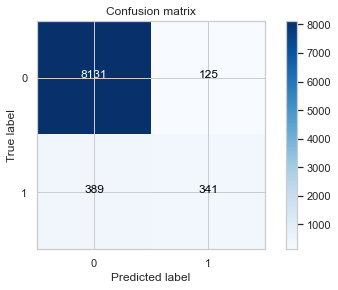

,Model,Accuracy,Precision,Recall,AUC,F1
0,RandomForest (Default),0.94,0.47,0.73,0.73,0.57


In [136]:
print_model_metrics(y_test,y_pred_test,"RandomForest (Default)")

#### Hyperparameter Tuning

In [137]:
# GridSearch
param_grid = {
    'max_depth': [12,18],
    'n_estimators': [200],
    'max_features': [40],
    'min_samples_leaf': [10, 20],
    'min_samples_split': [10,20,30]
}

# Initializing the model
rf = RandomForestClassifier()
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1,verbose = 1,return_train_score=True)

**Note:** After some testing, we have arrived to the above parameters. Here, it is not shown because it takes a lot of time in running that code.

In [138]:
# Fitting the grid search to the data
rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: 

In [ ]:
# Accuracy Score
#print('Accuracy Score:',round(rf_grid_search.best_score_, 2))

### Building and Evaluating Final model for Random Forest

In [ ]:
rfc = RandomForestClassifier(max_depth=18,
                             max_features=40,
                             min_samples_leaf=10,
                             min_samples_split=20,
                             n_estimators=200,
                             n_jobs = -1)
rfc.fit(X_train,y_train)

In [ ]:
# Predictions
y_pred_test = rfc.predict(X_test)

In [ ]:
# Confusion Matrix
print_model_metrics(y_test,y_pred_test,'RandomForest (Hyper)')

### XGBOOST

In [ ]:
# Creating a backup copy to run on this model
telecom_xgboost_df = telecom_df_final.copy()

In [ ]:
# Splitting into X and y
y = telecom_xgboost_df["churn"]
X = telecom_xgboost_df.drop(["churn","mobile_number"],axis=1)

In [ ]:
# Splitting into Train and Test
X_train, X_test, y_train, y_test = train_test_split(scale_data(X), y, train_size=0.7, random_state=100)

In [ ]:
# Fitting the Training data on XGBOOST model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

In [ ]:
# Predictions
y_pred_test = xgb_model.predict(X_test)

In [ ]:
# Model Metrics and Accuracy Score
print_model_metrics(y_test, y_pred_test ,'XGBoost (Default)')

#### Hyperparameteric Tuning

In [ ]:
# KFold 
folds = 5

# Hyperparameters
param_grid = {'learning_rate': [0.1,0.2,0.3], 
             'subsample': [0.3,0.4,0.5]}          


# Model Initialization
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'accuracy', # accuracy
                        cv = folds, 
                        n_jobs = -1,
                        verbose = 1,
                        return_train_score=True)  

In [ ]:
# Fitting the model
model_cv.fit(X_train, y_train)    

In [ ]:
# Cross-Validation Results
cv_results_xgboost = pd.DataFrame(model_cv.cv_results_)
cv_results_xgboost['param_learning_rate'] = cv_results_xgboost['param_learning_rate'].astype('float')

In [ ]:
# Accuracy Score
print('Accuracy Score:', round(model_cv.best_score_, 2))

In [ ]:
# Customized function for plotting XGBOOST
def plot_for_xboost(param_grid,cv_results):
    plt.figure(figsize=(18,5))
    for n, subsample in enumerate(param_grid['subsample']):
        # subplot 1/n
        plt.subplot(1,len(param_grid['subsample']), n+1)
        df = cv_results[cv_results['param_subsample']==subsample]

        plt.plot(df["param_learning_rate"], df["mean_test_score"])
        plt.plot(df["param_learning_rate"], df["mean_train_score"])
        plt.xlabel('learning_rate')
        plt.ylabel('AUC')
        plt.title("subsample={0}".format(subsample))
        plt.ylim([0.60, 1])
        plt.legend(['test score', 'train score'], loc='lower right')
        plt.xscale('log')

In [ ]:
param_grid1 = {'learning_rate': [0.1,0.2,0.3], 'subsample': [0.3,0.4,0.5]}  
plot_for_xboost(param_grid1,cv_results_xgboost)Inference:



#### Inference:

* Results show that subsample size of 0.5 and learning_rate of 0.3 seems optimal.

In [ ]:
# Chosen Hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
params = {'learning_rate': [0.3],
          'max_depth': [2], 
          'n_estimators':[200],
          'subsample':[0.5],
         'objective':['binary:logistic']}

# fit model on training data
model = XGBClassifier(params = params,max_depth=2, n_estimators=200)
model.fit(X_train, y_train)

In [ ]:
# Predictions
y_pred_test = model.predict(X_test)

In [ ]:
print_model_metrics(y_test, y_pred_test,'XGBoost (Hyper Tuned)')

In [ ]:
# Plotting Feature Importances
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x = 'tenure_range', hue = 'churn',data = tenure_data,palette=("gist_rainbow"))
plt.show()

print('Important Indicators:')
col = list(X_scaled.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head(15)

## Recommendations


* Less number of 'High Value Customers' are churning but for last 6 month, no new high valued customer is onboarded which the company should look into.
* Customers with less than 4 years of tenure are more likely to churn.
* Average Revenue per user is the most important feature.
* Incoming and Outgoing Calls in 8th month should be focused on because if their usage is decreased, they are more likely to churn.
* 2G/3G services should be improved.

In [ ]:
model_summary

In [ ]:
### Inference:

* RandomForest produce good accuracy of 0.95.
* XGBOOST after tuning also produce an accuracy of 0.95.
* We should prefer XGBOOST with parameters tuned for future predictions of the model.